# PXD013277

## Human cell lysate with added E. coli

### Data analysis performed by Phil Wilmarth, PSR Core OHSU

#### June 16, 2020

---

- [Overview](#overview) 
- [Library and data loading](#load_data) 
- [Clustering and normalization](#TMM)
- [1. 7.5 versus 15 (2-fold)](#7pt5_15) 
- [2. 7.5 versus 45 (6-fold)](#7pt5_45) 
- [3. 15 versus 45 (3-fold)](#15_45) 
- [Summary](#summary)

---

## <a name="overview"></a>Overview

The data is from the [PXD013277](http://proteomecentral.proteomexchange.org/cgi/GetDataset?ID=PXD013277) PRIDE archive. The human cells are the MCF7 cell line. E. coli lysate was spiked in at 3 different relative levels. The mixes were labeled with TMT 10-plex and analyzed in a large-scale fractionation using a Q Exactive HF instrument. The human samples and the E. coli samples are replicates of one cell lysate pellet. I think the digestions and labeling reactions are all independent. We will have some experimental variation, but not as much as true independent biological replicates. 

Sample Key:

Channel|E. coli (ug)|MCF7 (ug)|Total (ug)|Human Fraction
-------|------------|---------|----------|--------------
126C|7.5|70|77.5|0.90
127N|7.5|70|77.5|0.90
127C|7.5|70|77.5|0.90
128N|15|70|85|0.82
128C|15|70|85|0.82
129N|15|70|85|0.82
129C|15|70|85|0.82
130N|45|70|115|0.61
130C|45|70|115|0.61
131N|45|70|115|0.61 

The data is described in [this MCP paper](https://www-mcponline-org.liboff.ohsu.edu/content/mcprot/early/2020/03/23/mcp.TIR119.001646.full.pdf) (free ahead of press). Briefly, samples were reduced and alkylated, digested with LysC and trypsin in an SP3 bead protocol. The first-dimension separation was a peptide IEF-IPG method that resulted in 72 fractions. Each fraction was run on a standard reverse phase column into a Q Exactive HF instrument. Instrument parameters looked typical for an MS2 TMT experiment on this platform.

The data was downloaded from PRIDE (about 29 GB) and converted to compressed text files using [MSConvert](http://proteowizard.sourceforge.net/). The re-analysis used the [PAW pipeline](https://github.com/pwilmart/PAW_pipeline). A combined human and E. coli canonical reference proteome FASTA file was created using [fasta_utilities tools](https://github.com/pwilmart/fasta_utilities). A wide tolerance [Comet](http://comet-ms.sourceforge.net/) search (1.25 Da for parent ions) was used with recommended settings for high-resolution MS2 fragment ions. PSMs were filtered to 1% FDR. Protein inference used basic and extended parsimony analysis. TMT analysis used reporter ions from all unique (with respect to the final protein list) peptides summed into protein total intensities. Normalizations and statistical testing was done in edgeR using the [Jupyter notebook](https://jupyter.org/).

The RAW data files had 1,961,506 MS2 scans. At a 1% FDR, there were 303,201 scans that passed the score cutoffs (15.5% overall ID rate). There were about 10K protein IDs: 9,650 proteins excluding common contaminants, decoys, and proteins without any usable reporter ion signals using a two peptides per protein criterion.

The data here was manually normalized so that the total intensities of human proteins in each channel are the same. EdgeR testing will be done without using the TMM normalization function.

### References

> Thompson, A., Schäfer, J., Kuhn, K., Kienle, S., Schwarz, J., Schmidt, G., Neumann, T. and Hamon, C., 2003. Tandem mass tags: a novel quantification strategy for comparative analysis of complex protein mixtures by MS/MS. Analytical chemistry, 75(8), pp.1895-1904.

> Wilmarth, P.A., Riviere, M.A. and David, L.L., 2009. Techniques for accurate protein identification in shotgun proteomic studies of human, mouse, bovine, and chicken lenses. Journal of ocular biology, diseases, and informatics, 2(4), pp.223-234.

> Robinson, M.D., McCarthy, D.J. and Smyth, G.K., 2010. edgeR: a Bioconductor package for differential expression analysis of digital gene expression data. Bioinformatics, 26(1), pp.139-140.

---

## Load the necessary R libraries

In [1]:
# library imports
library(tidyverse)
library(scales)
library(limma)
library(edgeR)
library(psych)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘psych’


The following objects are masked from ‘package:scales’:

    alpha, rescale


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha




## Define common functions for notebook use

In [2]:
# ================== TMM normalization from DGEList object =====================
apply_tmm_factors <- function(y, color = NULL, plot = TRUE) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute and print "Sample loading" normalization factors
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size
    cat("\nLibrary size factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), lib_facs))
    
    # compute and print TMM normalization factors
    tmm_facs <- 1/y$samples$norm.factors
    cat("\nTrimmed mean of M-values (TMM) factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), tmm_facs))
    
    # compute and print the final correction factors
    norm_facs <- lib_facs * tmm_facs
    cat("\nCombined (lib size and TMM) normalization factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), norm_facs))

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(tmt_tmm), col = color, notch = TRUE, main = "TMM Normalized data")
    }
    tmt_tmm
}

# ================= reformat edgeR test results ================================
collect_results <- function(df, tt, x, xlab, y, ylab) {
    # Computes new columns and extracts some columns to make results frame
        # df - data in data.frame
        # tt - top tags table from edgeR test
        # x - columns for first condition
        # xlab - label for x
        # y - columns for second condition
        # ylab - label for y
        # returns a new dataframe
    
    # condition average vectors
    ave_x <- rowMeans(df[x])
    ave_y <- rowMeans(df[y])
    
    # FC, direction, candidates
    fc <- ifelse(ave_y > ave_x, (ave_y / ave_x), (-1 * ave_x / ave_y))
    direction <- ifelse(ave_y > ave_x, "up", "down")
    candidate <- cut(tt$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                     labels = c("high", "med", "low", "no"))
    
    # make data frame
    temp <- cbind(df[c(x, y)], data.frame(logFC = tt$logFC, FC = fc, 
                                          PValue = tt$PValue, FDR = tt$FDR, 
                                          ave_x = ave_x, ave_y = ave_y, 
                                          direction = direction, candidate = candidate, 
                                          Acc = tt$genes)) 
    
    # fix column headers for averages
    names(temp)[names(temp) %in% c("ave_x", "ave_y")]  <- str_c("ave_", c(xlab, ylab))    
    
    temp # return the data frame
}

# =============== p-value plots ================================================
pvalue_plots <- function(results, ylim, title) {
    # Makes p-value distribution plots
        # results - results data frame
        # ylim - ymax for expanded view
        # title - plot title
    p_plot <- ggplot(results, aes(PValue)) + 
        geom_histogram(bins = 100, fill = "white", color = "black") +
        geom_hline(yintercept = mean(hist(results$PValue, breaks = 100, 
                                     plot = FALSE)$counts[26:100]))

    # we will need an expanded plot
    p1 <- p_plot + ggtitle(str_c(title, " p-value distribution"))
    p2 <- p_plot + coord_cartesian(xlim = c(0, 1.0), ylim = c(0, ylim)) + ggtitle("p-values expanded")
    grid.arrange(p1, p2, nrow = 2) # from gridExtra package
}

# ============= log2 fold-change distributions =================================
log2FC_plots <- function(results, range, title) {
    # Makes faceted log2FC plots by candidate
        # results - results data frame
        # range - plus/minus log2 x-axis limits
        # title - plot title
    ggplot(results, aes(x = logFC, fill = candidate)) +
        geom_histogram(binwidth=0.1, color = "black") +
        facet_wrap(~candidate) +
        ggtitle(title) + 
        coord_cartesian(xlim = c(-range, range))
}

# ========== Setup for MA and volcano plots ====================================
transform <- function(results, x, y) {
    # Make data frame with some transformed columns
        # results - results data frame
        # x - columns for x condition
        # y - columns for y condition
        # return new data frame
    df <- data.frame(log10((results[x] + results[y])/2), 
                     log2(results[y] / results[x]), 
                     results$candidate,
                     -log10(results$FDR))
    colnames(df) <- c("A", "M", "candidate", "P")
    
    df # return the data frame
}

# ========== MA plots using ggplot =============================================
MA_plots <- function(results, x, y, title) {
    # makes MA-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots 
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # 2-fold change lines
    ma_lines <- list(geom_hline(yintercept = 0.0, color = "black"),
                     geom_hline(yintercept = 1.0, color = "black", linetype = "dotted"),
                     geom_hline(yintercept = -1.0, color = "black", linetype = "dotted"))

    # make main MA plot
    ma <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("logFC (", y, "/", x, ")")) +
        scale_x_continuous("Ave_intensity") +
        ggtitle(title) + 
        ma_lines
    
    # make separate MA plots
    ma_facet <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("log2 FC (", y, "/", x, ")")) +
        scale_x_continuous("log10 Ave_intensity") +
        ma_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)"))

    # make the plots visible
    print(ma)
    print(ma_facet)
}    

# ========== Scatter plots using ggplot ========================================
scatter_plots <- function(results, x, y, title) {
    # makes scatter-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots
    
    # 2-fold change lines
    scatter_lines <- list(geom_abline(intercept = 0.0, slope = 1.0, color = "black"),
                          geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          scale_y_log10(),
                          scale_x_log10())

    # make main scatter plot
    scatter <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        ggtitle(title) + 
        scatter_lines

    # make separate scatter plots
    scatter_facet <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scatter_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)")) 

    # make the plots visible
    print(scatter)
    print(scatter_facet)
}

# ========== Volcano plots using ggplot ========================================
volcano_plot <- function(results, x, y, title) {
    # makes a volcano plot
        # results - a data frame with edgeR results
        # x - string for the x-axis column
        # y - string for y-axis column
        # title - plot title string
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # build the plot
    ggplot(temp, aes(x = M, y = P)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        xlab("log2 FC") +
        ylab("-log10 FDR") +
        ggtitle(str_c(title, " Volcano Plot"))
}

# ============== individual protein expression plots ===========================
# function to extract the identifier part of the accesssion
get_identifier <- function(accession) {
    identifier <- str_split(accession, "\\|", simplify = TRUE)
    identifier[,3]
}

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

plot_top_tags <- function(results, nleft, nright, top_tags) {
    # results should have data first, then test results (two condition summary table)
    # nleft, nright are number of data points in each condition
    # top_tags is number of up and number of down top DE candidates to plot
    # get top ipregulated
    up <- results %>% 
        filter(logFC >= 0) %>%
        arrange(FDR)
    up <- up[1:top_tags, ]
    
    # get top down regulated
    down <- results %>% 
        filter(logFC < 0) %>%
        arrange(FDR)
    down <- down[1:top_tags, ]
    
    # pack them
    proteins <- rbind(up, down)
        
    color = c(rep("red", nleft), rep("blue", nright))
    for (row_num in 1:nrow(proteins)) {
        row <- proteins[row_num, ]
        vec <- as.vector(unlist(row[1:(nleft + nright)]))
        names(vec) <- colnames(row[1:(nleft + nright)])
        title <- str_c(get_identifier(row$Acc), ", int: ", scientific(mean(vec), 2), 
                       ", FDR: ", scientific(row$FDR, digits = 3), 
                       ", FC: ", round(row$FC, digits = 1),
                       ", ", row$candidate)
        barplot(vec, col = color, main = title,
                cex.main = 1.0, cex.names = 0.7, cex.lab = 0.7)
    }    
}

## <a name="load_data"></a>Load the TMT intensity data

The data was gently prepped in Excel to remove contaminants, decoys, and proteins without intensities. The data was normalized manually in Excel so that the sum of human protein intensity totals were the same across the channels. We have an accessions column and a column to denote human or E. coli species. There are the 10 TMT channels.

In [3]:
# load the IRS-normalized data and check the table
data_all <- read_tsv("human_matched_input.txt")

# save gene names for edgeR so we can double check that results line up
accessions <- data_all$Accession
species <- data_all$HorE

# get just the TMT columns
data_tmt <- select(data_all, -Accession, -HorE)

# see how many rows of data we have
length(accessions)

Parsed with column specification:
cols(
  Accession = col_character(),
  HorE = col_character(),
  A_70_7pt5 = col_double(),
  B_70_7pt5 = col_double(),
  C_70_7pt5 = col_double(),
  A_70_15 = col_double(),
  B_70_15 = col_double(),
  C_70_15 = col_double(),
  D_70_15 = col_double(),
  A_70_45 = col_double(),
  B_70_45 = col_double(),
  C_70_45 = col_double()
)



[1] 9650

### Use data from all conditions for edgeR analysis

We are defining the groups that will be compared explicitly and using all of the samples for variance estimates. We will put the data into a data frame, grouped by condition. We will define some column indexes for each condition, set some colors for plotting, and see how the data cluster by condition.

In [4]:
# define the 3 spike-in groups
low <- 1:3
med <- 4:7
high <- 8:10

# set some colors by condition
colors = c(rep('red', length(low)), rep('blue', length(med)), rep('green', length(high)))

## <a name="TMM"></a>Skip TMM normalization and check final clustering 

We will the data into edgeR data structures and do an end run around the trimmed mean of M-values (TMM) normalization.

group lib.size     norm.factors
A_70_7pt5 low   112397154348 1           
B_70_7pt5 low   112397154348 1           
C_70_7pt5 low   112397154348 1           
A_70_15   med   112397154348 1           
B_70_15   med   112397154348 1           
C_70_15   med   112397154348 1           
D_70_15   med   112397154348 1           
A_70_45   high  112397154348 1           
B_70_45   high  112397154348 1           
C_70_45   high  112397154348 1

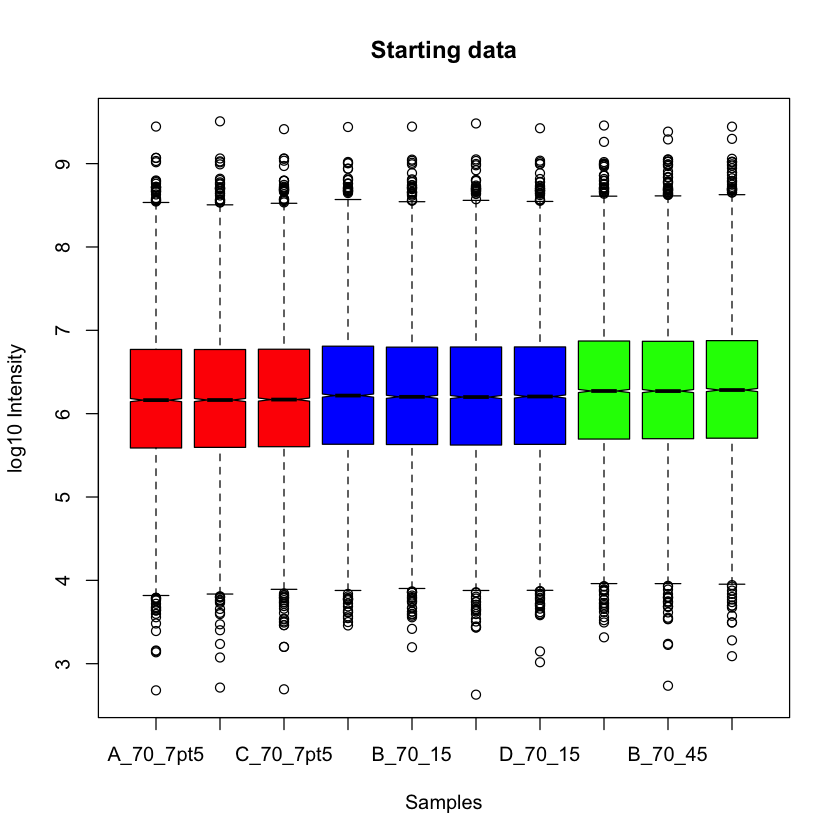

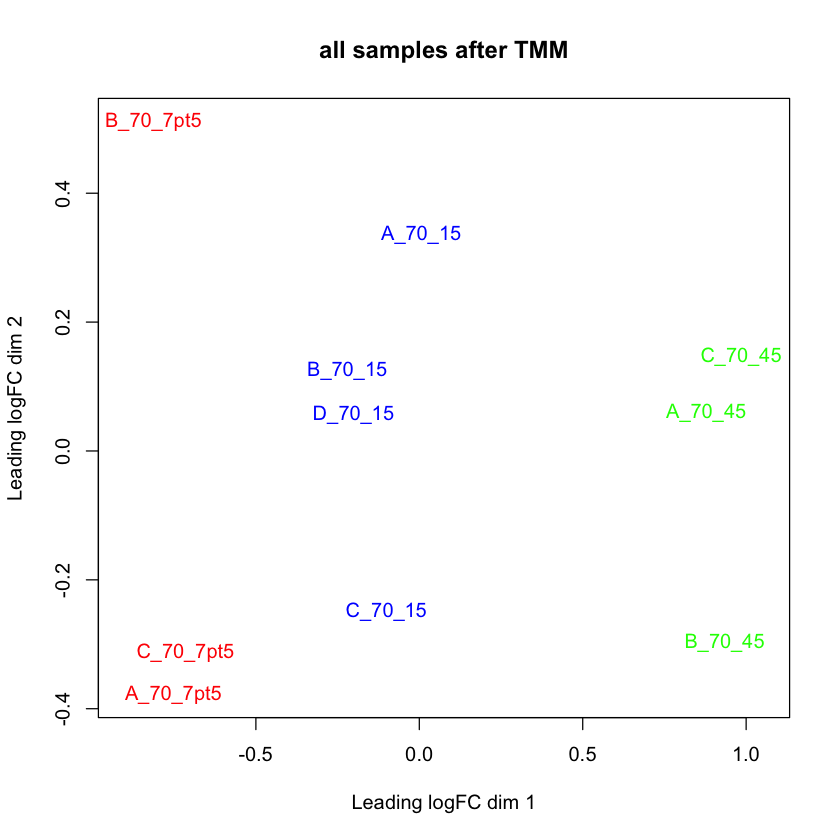

In [5]:
# bugger library size here? (to stop any normalization within edgeR)
size <- mean(colSums(data_tmt))
size <- rep(size, ncol(data_tmt))

# load data into edgeR objects
group = c(rep("low", length(low)), rep("med", length(med)), rep("high", length(high)))
y <- DGEList(counts = data_tmt, lib.size = size, group = group, gene = accessions)

# check the data and compute dispersion
y$samples

# copy data 
tmt_tmm <-  data_tmt

# check the clustering
boxplot(log10(data_tmt), col = colors, xlab = "Samples", ylab = "log10 Intensity",
        main = "Starting data", notch = TRUE)
plotMDS(y, col = colors, main = "all samples after TMM")

### We have the data in edgeR objects without any additional normailzations

# EdgeR statistical testing starts here

## Compute the shared variance trend

One of the most powerful features of edgeR (and limma) is computing variances across larger numbers of genes (proteins) to get more robust variance estimates for small replicate experiments. Here, we have 18 samples across all conditions to use to improve the variance estimates and reduce false positive differential expression (DE) candidates. We have an edgeR `estimateDisp` function that does all of this and a visualization function to check the result.

We loaded the IRS data into `DGEList` object `y` a few cells above and did the normalization step. We need to estimate the dispersion parameters before we can do the actual statistical testing. This only needs to be done once. Each exact test will take two conditions and compare them using the normalization factors and dispersion estimates saved in `y`.

Design matrix not provided. Switch to the classic mode.


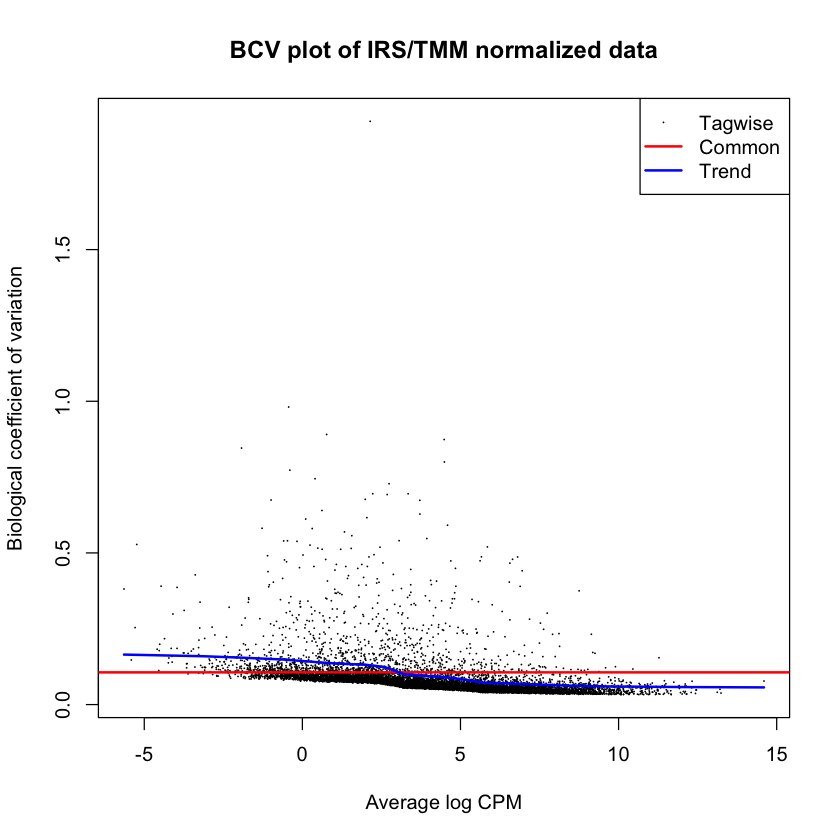

In [6]:
# compute dispersions and plot BCV
y <- estimateDisp(y)
plotBCV(y, main = "BCV plot of IRS/TMM normalized data")

## <a name="7pt5_15"></a>(1) 7.5 versus 15 for E. coli

We will specify the pair of interest for the exact test in edgeR and use the experiment-wide dispersion. The `decideTestsDGE` call will tell us how many up and down regulated candidates we have at an FDR of 0.10. The `topTags` call does the Benjamini-Hochberg multiple testing corrections. We save the test results in `tt`. We use a handy MA (mean-average) plotting function from `limma` to visualize the DE candidates, and then check the p-value distribution.

       med-low
Down        47
NotSig    7408
Up        2195

genes                logFC     logCPM    PValue       FDR         
158  sp|P09373|PFLB_ECOLI 0.7068180 10.058244 6.617016e-40 6.385421e-36
110  sp|P60422|RL2_ECOLI  0.6429992 10.438795 1.869147e-39 9.018636e-36
1046 sp|P08622|DNAJ_ECOLI 0.6296707  7.598476 6.016052e-39 1.935164e-35
1027 sp|P0A9D8|DAPD_ECOLI 0.7040850  7.618866 2.002070e-37 4.829994e-34
862  sp|P0ADG7|IMDH_ECOLI 0.6515983  7.913320 1.377934e-36 2.659413e-33
381  sp|P0A7R1|RL9_ECOLI  0.6357992  9.059921 3.586051e-35 5.767565e-32
68   sp|P0AE08|AHPC_ECOLI 0.7376685 10.966635 7.296701e-35 1.005902e-31
722  sp|P0A817|METK_ECOLI 0.6413172  8.202775 1.704128e-34 2.055605e-31
248  sp|P0A7S9|RS13_ECOLI 0.6758364  9.523020 2.013079e-34 2.158468e-31
281  sp|P09151|LEU1_ECOLI 0.6886111  9.368490 3.150860e-34 3.040580e-31

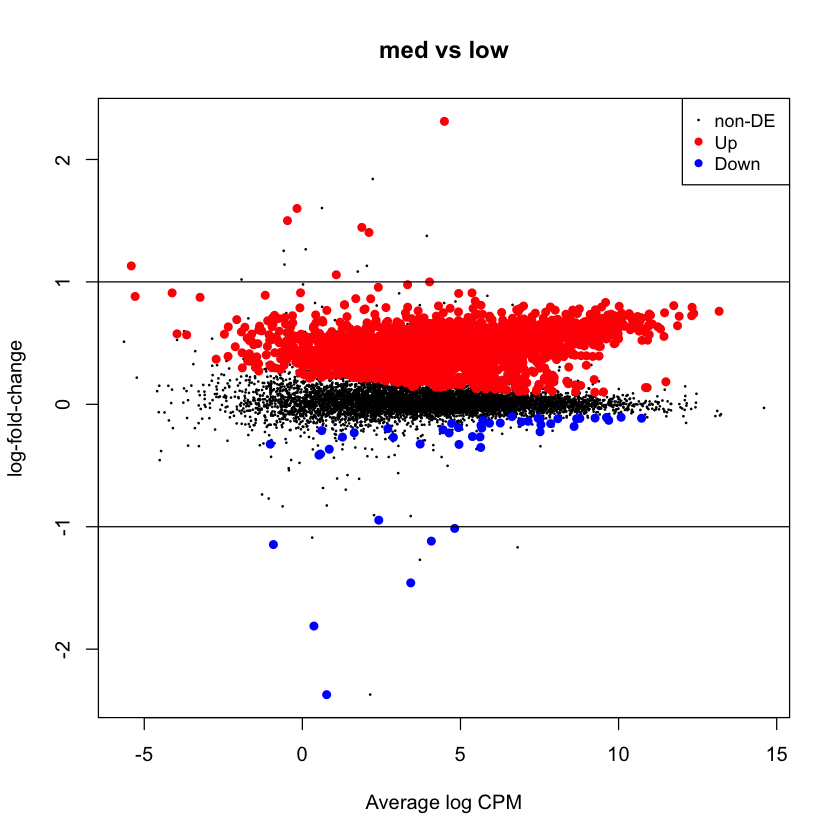

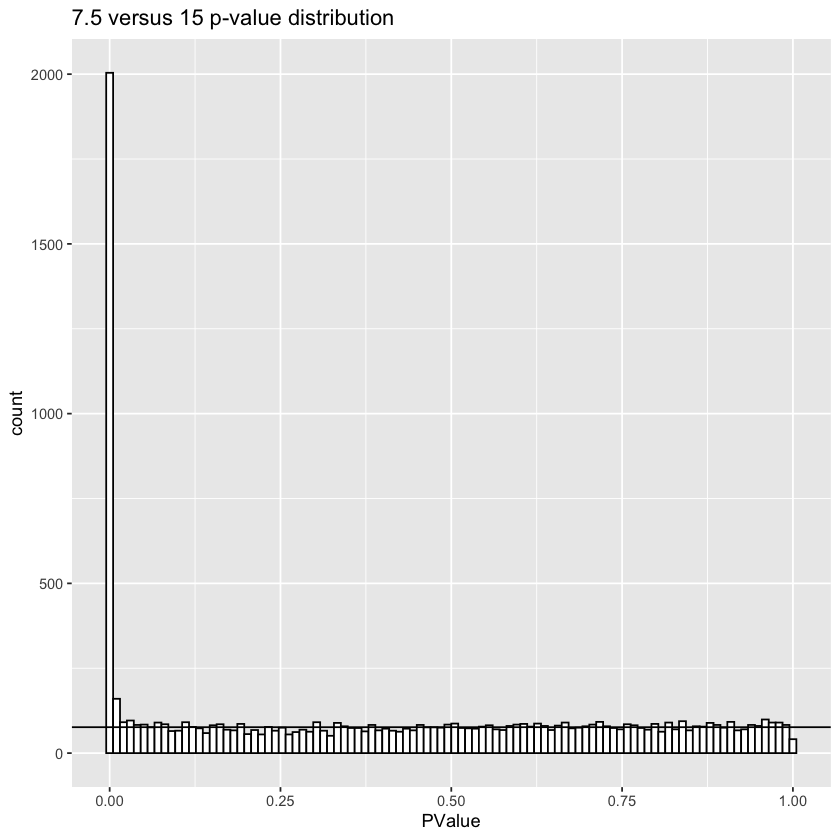

In [7]:
# the exact test object has columns like fold-change, CPM, and p-values
et <- exactTest(y, pair = c("low", "med"))

# this counts up, down, and unchanged genes (proteins) at 10% FDR
summary(decideTestsDGE(et, p.value = 0.10))

# the topTags function adds the BH FDR values to an exactTest data frame 
# make sure we do not change the row order (the sort.by parameter)!
topTags(et)$table
tt <- topTags(et, n = Inf, sort.by = "none")

# make an MD plot (like MA plot)
plotMD(et, p.value = 0.10)
abline(h = c(-1, 1), col = "black")

# check the p-value distribution
ggplot(tt$table, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(et$table$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
  ggtitle("7.5 versus 15 p-value distribution")

### We have 2,242 DE candidates

We have a nice number of DE candidates and all of the top tags are E. coli proteins. The p-value distribution looks nice. 

## Compute averages, flag candidates, and save the pair-wise test results

We will add the statistical testing results (logFC, p-values, and FDR), condition intensity averages, and candidate status to the `results` data frame (which has the TMM-normalized data) and also accumulate all of the three comparisons into `all_results`.

Even though we do not have many candidates, we will still make the MA plots, scatter plots, and volcano plot using ggplot2. We will also look at the distribution of log2 expression ratios separated by differential expression (DE) category. The Benjamini-Hochberg corrected edgeR p-values are used to categorize the DE candidates: no > 0.10 > low > 0.05 > med > 0.01 > high.

In [8]:
# get the results summary
results <- collect_results(tmt_tmm, tt$table, low, "low", med, "med")
results$species <- as.factor(species)

# make column names unique by adding comparison (for the accumulated frame)
results_temp  <- results
colnames(results_temp) <- str_c(colnames(results), "_low_med")

# accumulate the testing results
all_results <- results_temp

### Count candidates and look at fold-change distributions

candidate n   
1 high      1925
2 med        189
3 low        128
4 no        7408

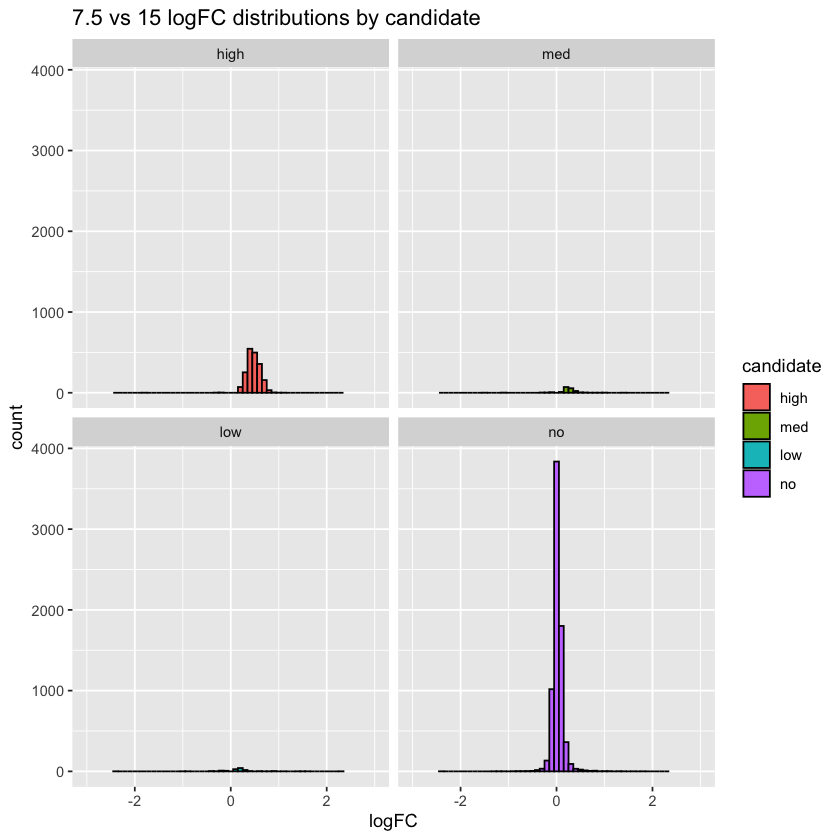

In [9]:
# see how many candidates by category
results %>% count(candidate)

# plot log2 fold-changes by category
ggplot(results, aes(x = logFC, fill = candidate)) +
  geom_histogram(binwidth=0.1, color = "black") +
  facet_wrap(~candidate) +
  coord_cartesian(xlim = c(-3, 3)) +
  ggtitle("7.5 vs 15 logFC distributions by candidate")

## Main summary plots

We have many comparisons to visualize, so we will use functions to generate a series of plots. We will make: an MA plot with candidates highlighted by color, faceted MA plots separated by candidate status, a scatter plot with candidates highlighted by color, faceted scatter plots separated by candidate status, and a volcano plot with candidates highlighted by color. The solid black lines in the MA and scatter plots are the 1-to-1 lines; the dotted lines are 2-fold change lines.

### MA plots

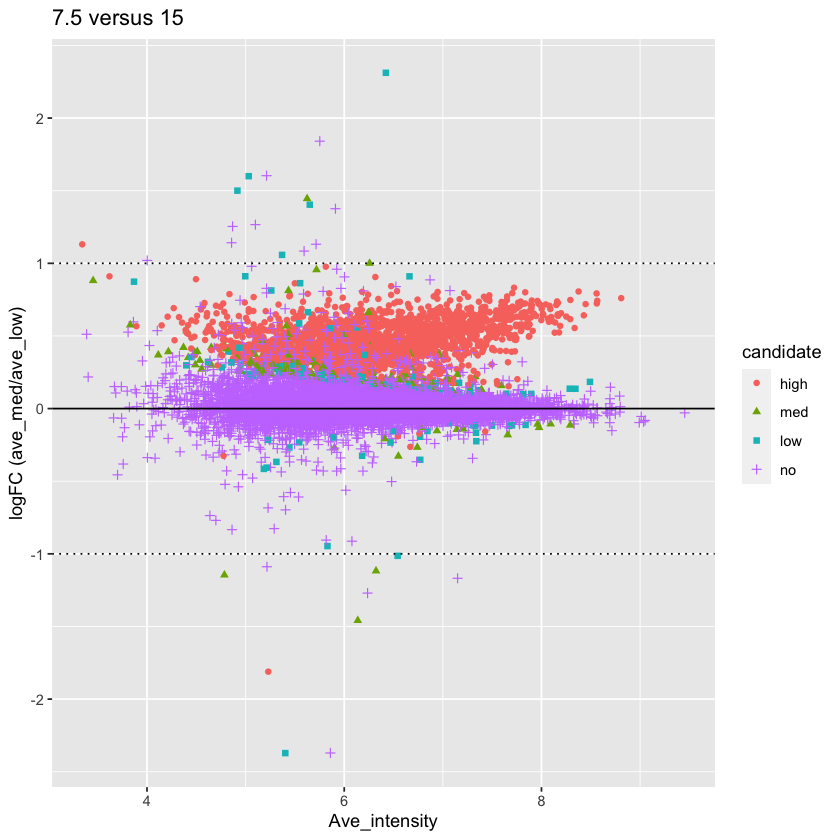

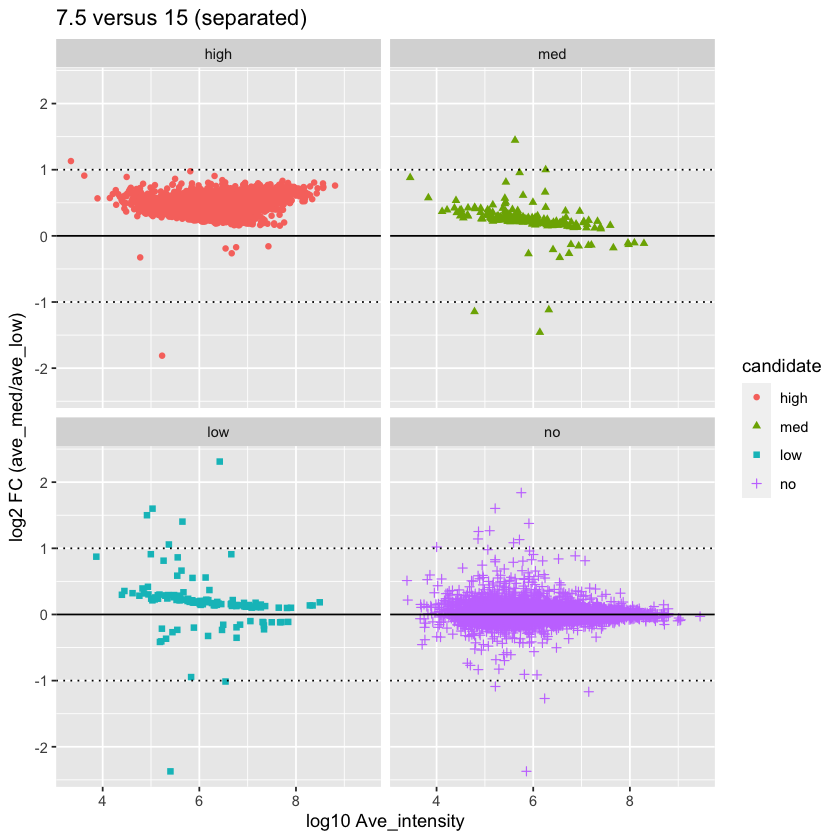

In [10]:
# make MA plots
MA_plots(results, "ave_low", "ave_med", "7.5 versus 15")

### Scatter plots

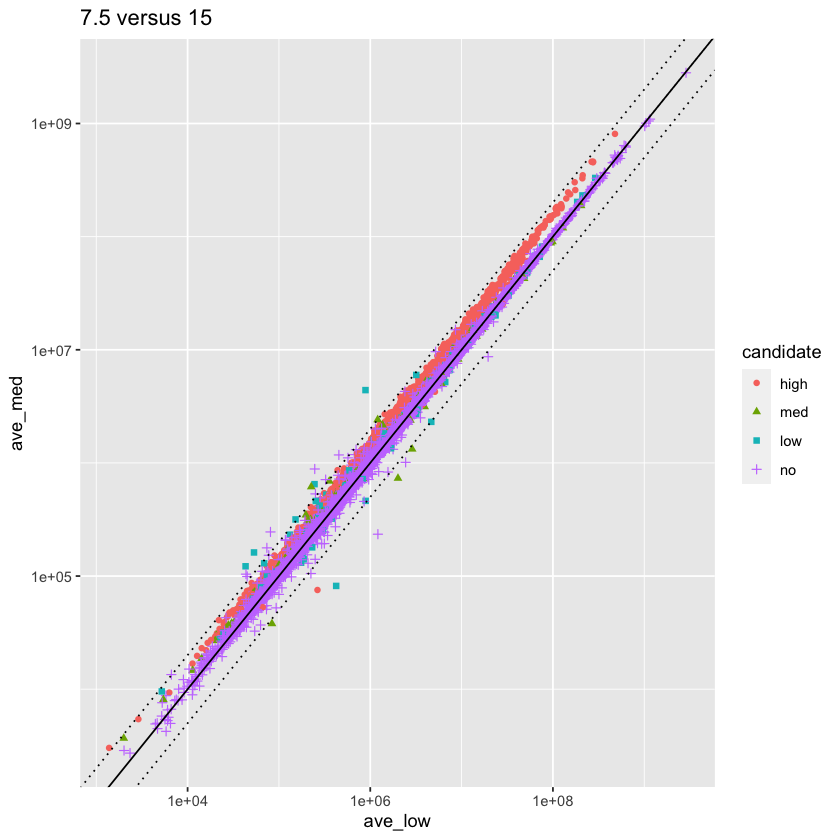

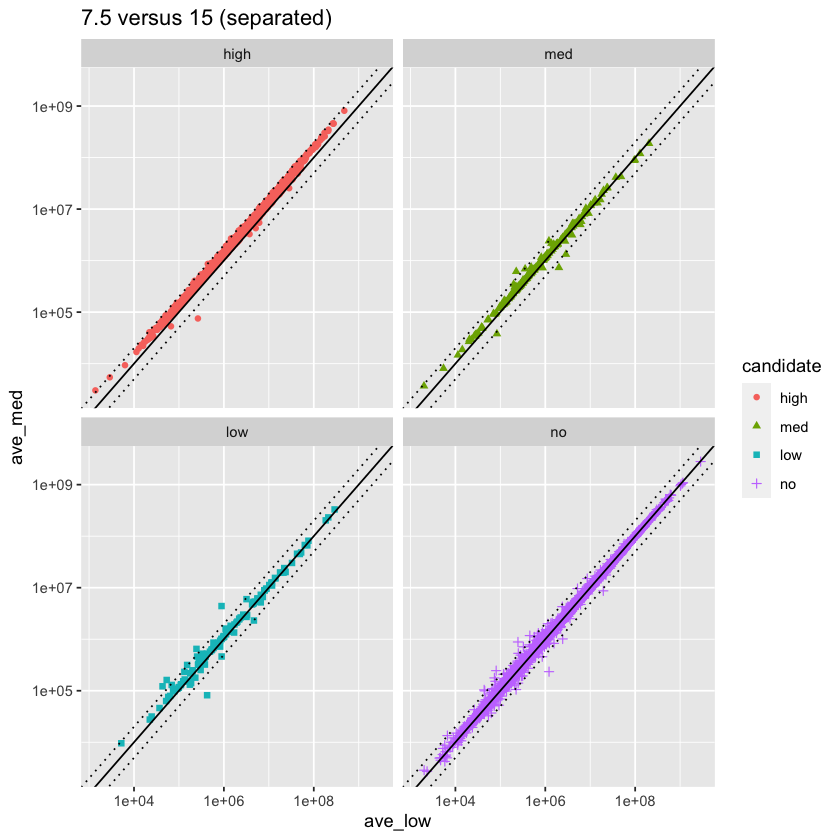

In [11]:
# make scatter plots
scatter_plots(results, "ave_low", "ave_med", "7.5 versus 15")

### Volcano plot

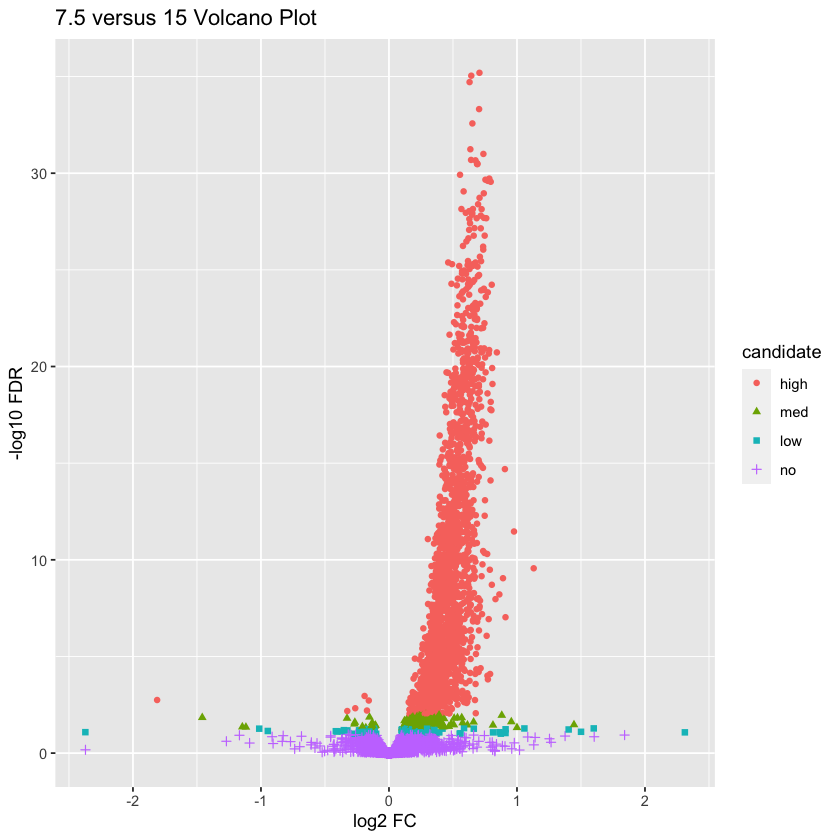

In [12]:
# make a volcano plot
volcano_plot(results, "ave_low", "ave_med", "7.5 versus 15")

### Candidates seem to be what we expected

We seem to have an unchanged distribution (hopefully the human proteins) and an over-expressed distribution (the E. coli proteins). The over-expressed proteins should be 2-fold different, but we are seeing smaller changes.

### Check some individual protein expression

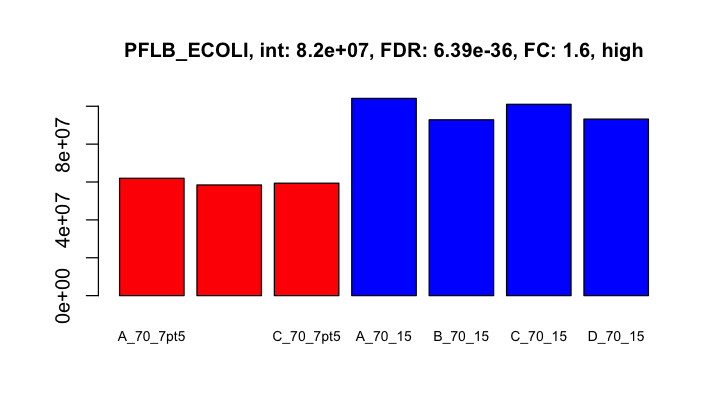

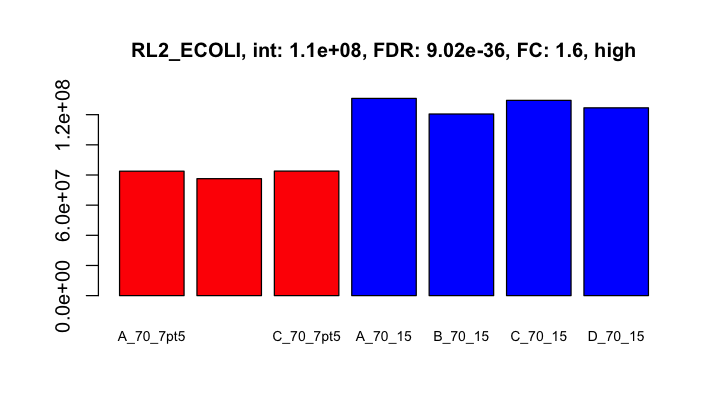

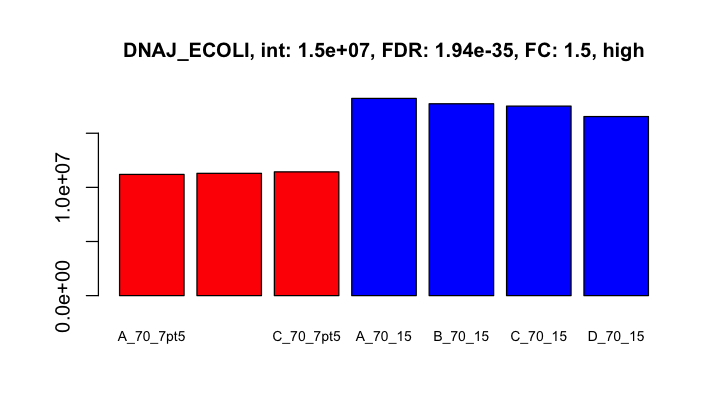

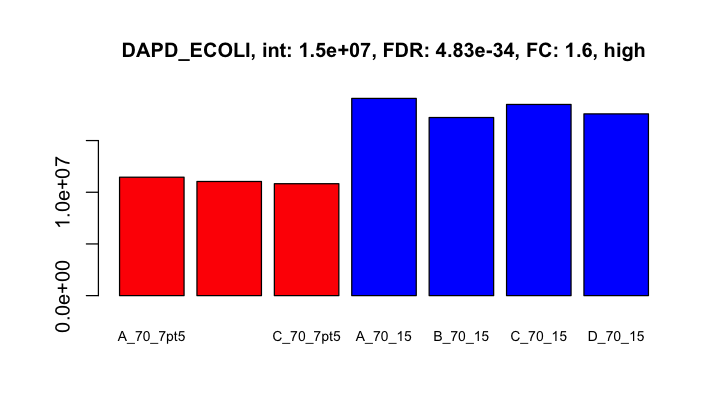

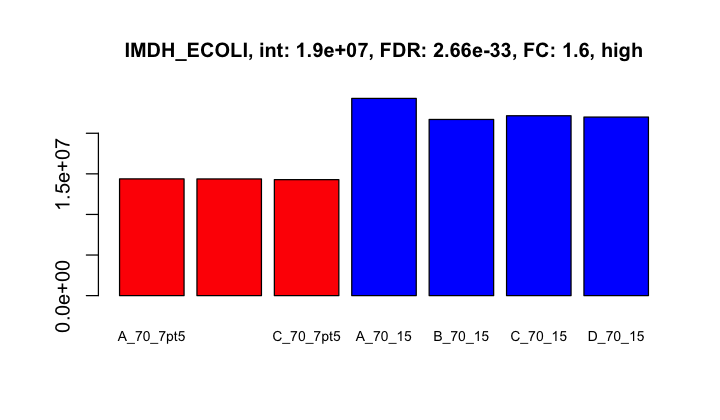

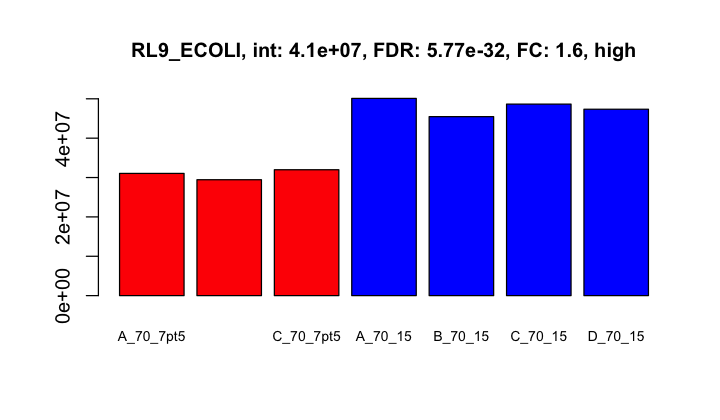

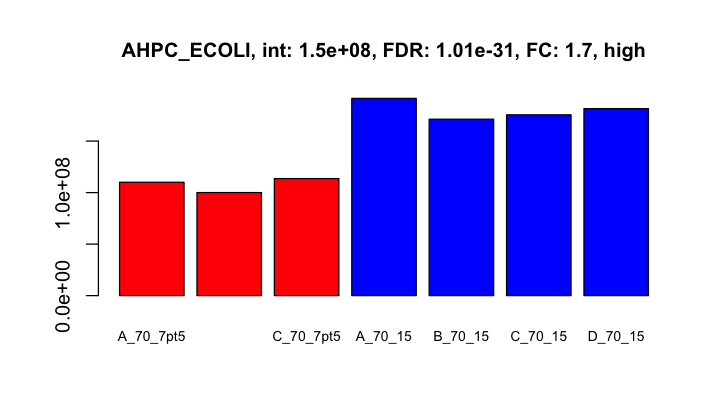

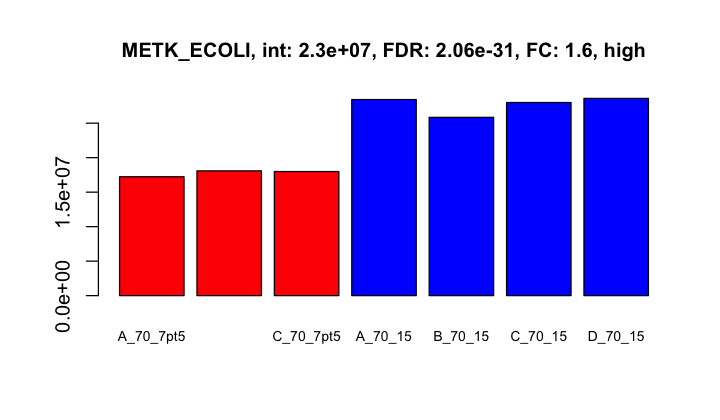

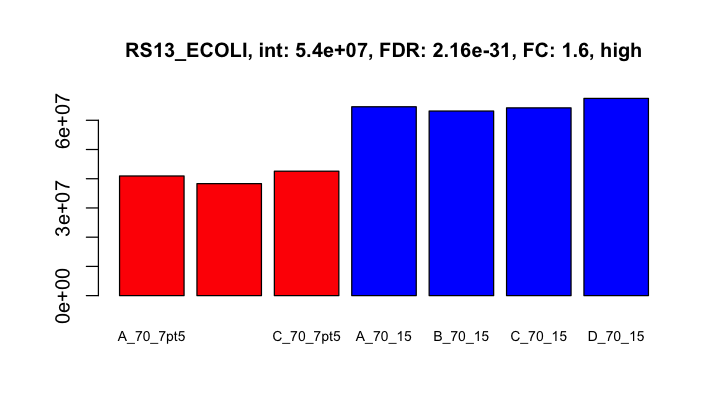

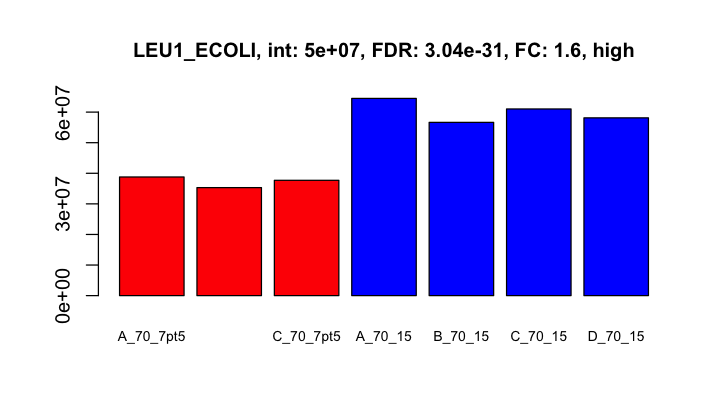

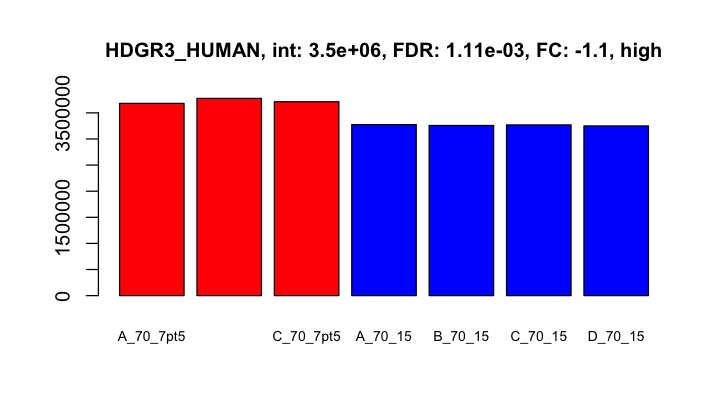

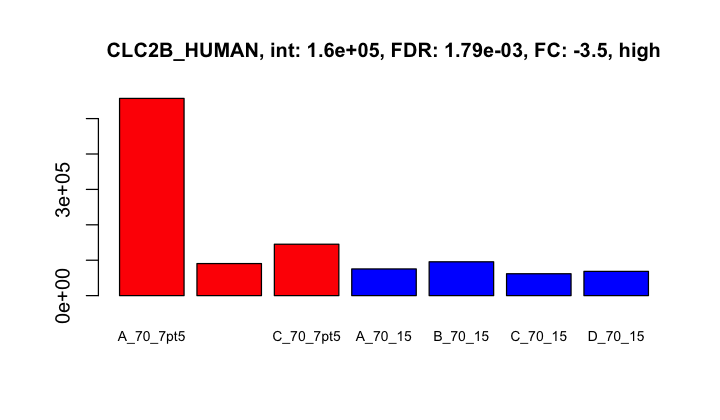

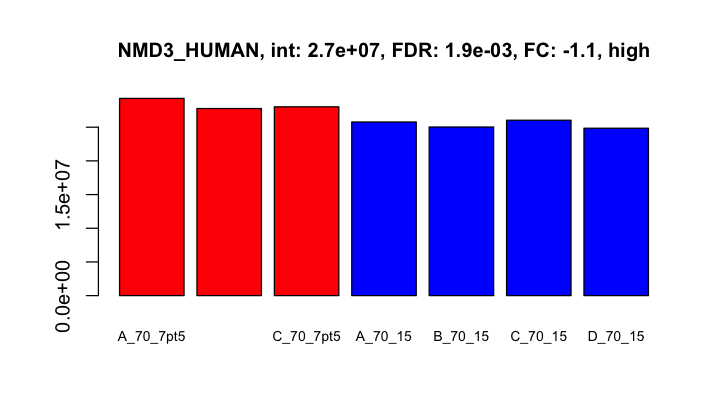

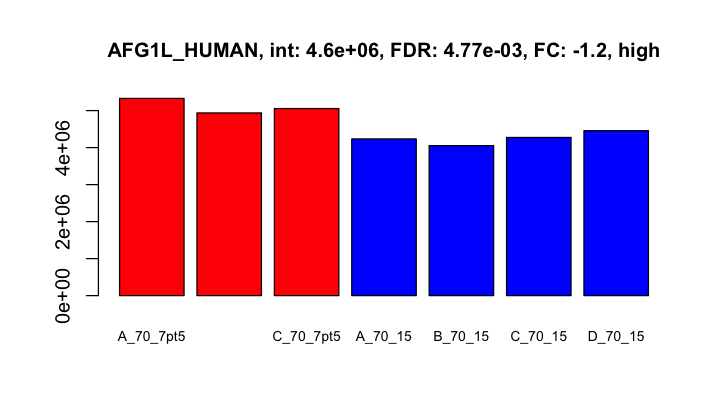

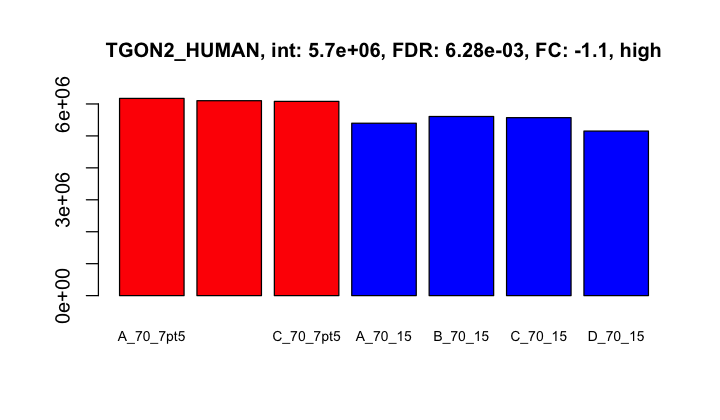

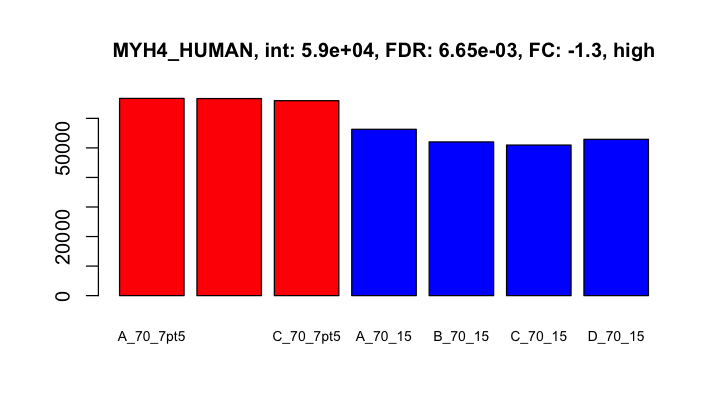

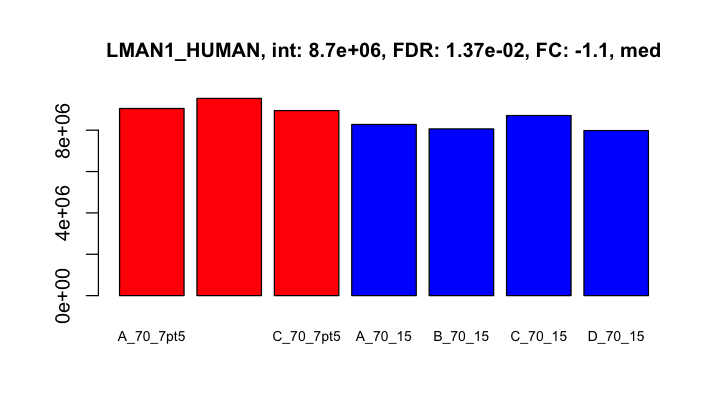

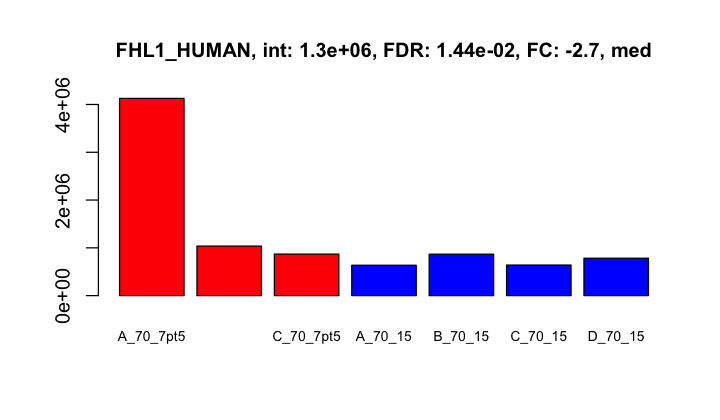

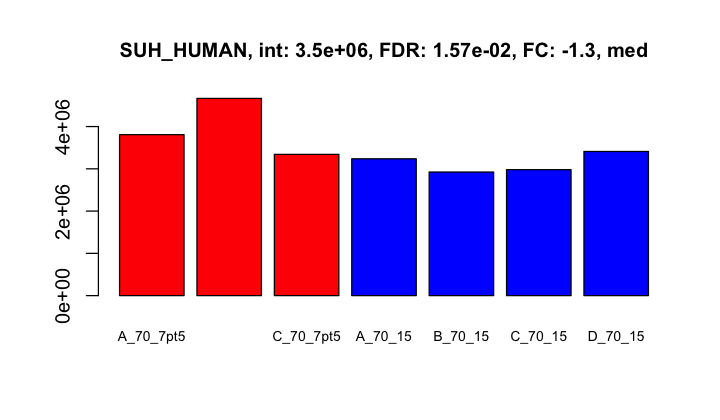

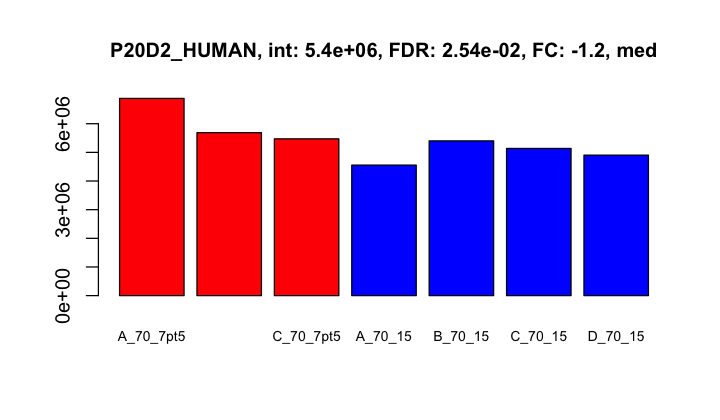

In [13]:
# look at the top candidates
set_plot_dimensions(6, 3.5)
plot_top_tags(results, 3, 4, 10)
set_plot_dimensions(7, 7)

## <a name="7pt5_45"></a> (2) 7.5 versus 45 microgram E. coli

We will do the same testing to compare 7.5 microgram of E. coli to 45 microgram of E. coli spiked into the human background.

       high-low
Down        359
NotSig     5443
Up         3848

genes                logFC    logCPM    PValue        FDR          
1046 sp|P08622|DNAJ_ECOLI 1.747612  7.598476 1.210135e-244 1.167780e-240
110  sp|P60422|RL2_ECOLI  1.742623 10.438795 9.110948e-237 4.396032e-233
381  sp|P0A7R1|RL9_ECOLI  1.772096  9.059921 1.201000e-221 3.863217e-218
538  sp|P63284|CLPB_ECOLI 1.568727  8.617150 2.784782e-218 6.718287e-215
248  sp|P0A7S9|RS13_ECOLI 1.870635  9.523020 6.291568e-213 1.214273e-209
929  sp|P0ADS6|YGGE_ECOLI 1.405702  7.780723 1.119706e-212 1.800861e-209
158  sp|P09373|PFLB_ECOLI 1.803054 10.058244 1.783364e-212 2.458495e-209
765  sp|P16700|CYSP_ECOLI 1.634943  8.103187 1.099223e-207 1.325938e-204
546  sp|P0AG44|RL17_ECOLI 1.474838  8.604477 6.485401e-205 6.953791e-202
862  sp|P0ADG7|IMDH_ECOLI 1.678704  7.913320 6.621994e-199 6.390224e-196

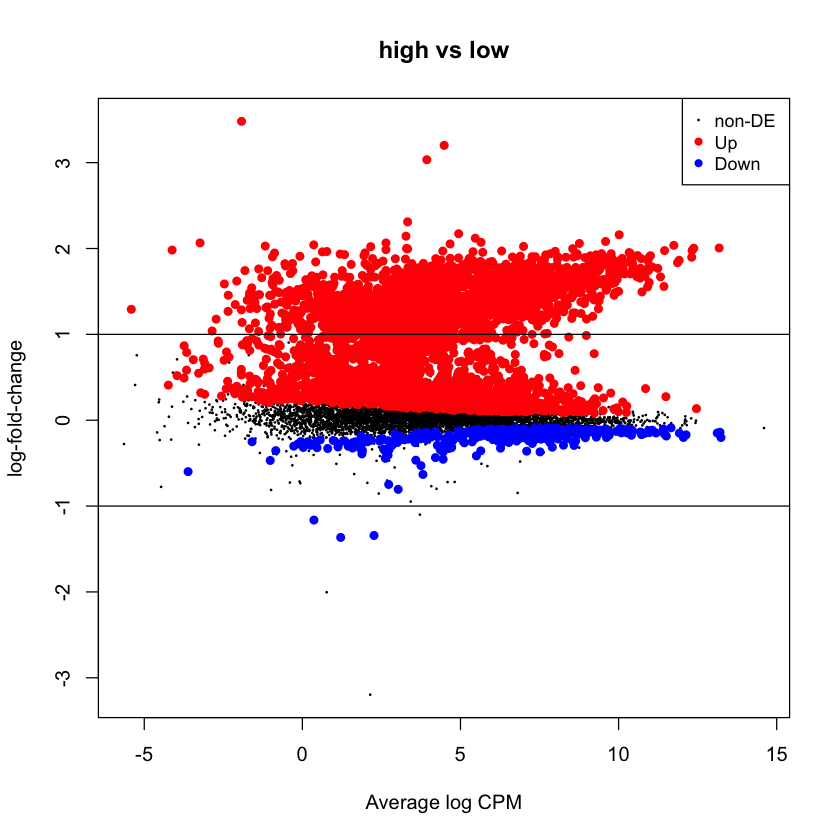

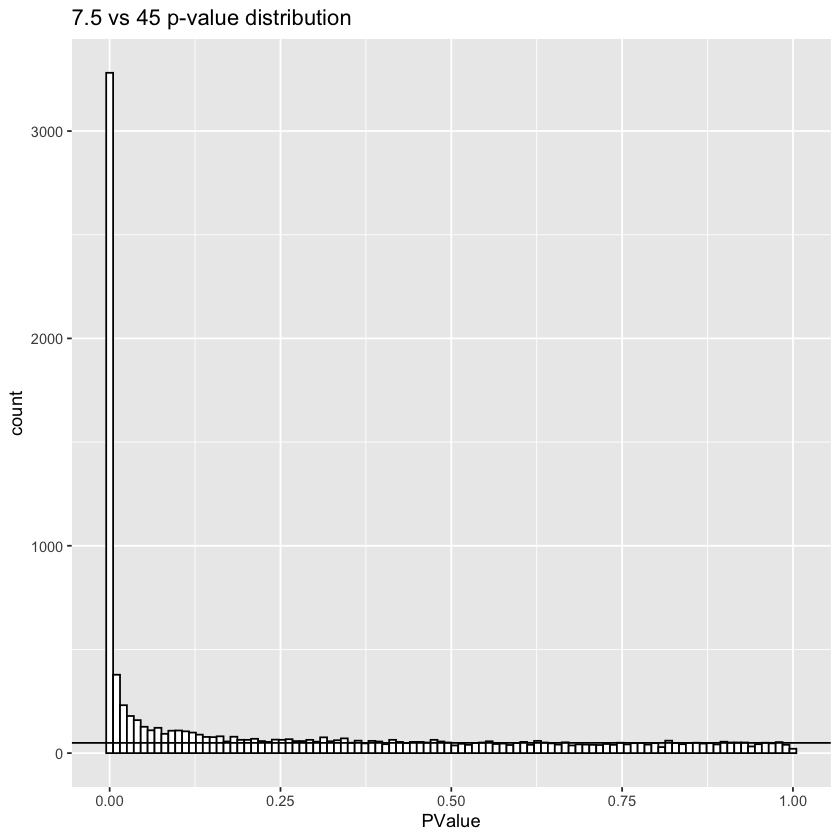

In [14]:
# the exact test object has columns like fold-change, CPM, and p-values
et <- exactTest(y, pair = c("low", "high"))

# this counts up, down, and unchanged genes (proteins) at 10% FDR
summary(decideTestsDGE(et, p.value = 0.10))

# the topTags function adds the BH FDR values to an exactTest data frame 
# make sure we do not change the row order (the sort.by parameter)!
topTags(et)$table
tt <- topTags(et, n = Inf, sort.by = "none")

# make an MD plot (like MA plot)
plotMD(et, p.value = 0.10)
abline(h = c(-1, 1), col = "black") # 2-fold change lines

# check the p-value distribution
ggplot(tt$table, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(et$table$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
  ggtitle("7.5 vs 45 p-value distribution")

### What happened !???

Something seems to have gone horribly wrong. The expectation would be that we still have two distributions, one unchanged with few if any significant expression changes and the other being a 6-fold difference in E. coli proteins that should be well separated from the unchanged distribution. We have about 2,200 identified E. coli proteins; however, we had the DE candidate number jump to 4,207. That means we now have about 2,000 human proteins that are significantly at different expression levels. We should not have any.

If we ignore the colors in the MA plot above, we seem to have two distributions that are somewhat separated. The unchanged distribution is severely carved up into significant over and under expression candidates. Something is seriously wrong here.


## Compute averages, flag candidates, and save the pair-wise test results

We will add the statistical testing results (logFC, p-values, and FDR), condition intensity averages, and candidate status to the `results` data frame (which has the TMM-normalized data) and also accumulate all of the three comparisons into `all_results`.

In [15]:
# get the results summary
results <- collect_results(tmt_tmm, tt$table, low, "low", high, "high")
results$species <- as.factor(species)

# make column names unique by adding comparison
results_temp  <- results
colnames(results_temp) <- str_c(colnames(results), "_low_high")

# accumulate the testing results
all_results <- cbind(all_results, results_temp)

### Count candidates and look at fold-change distributions

candidate n   
1 high      3184
2 med        595
3 low        428
4 no        5443

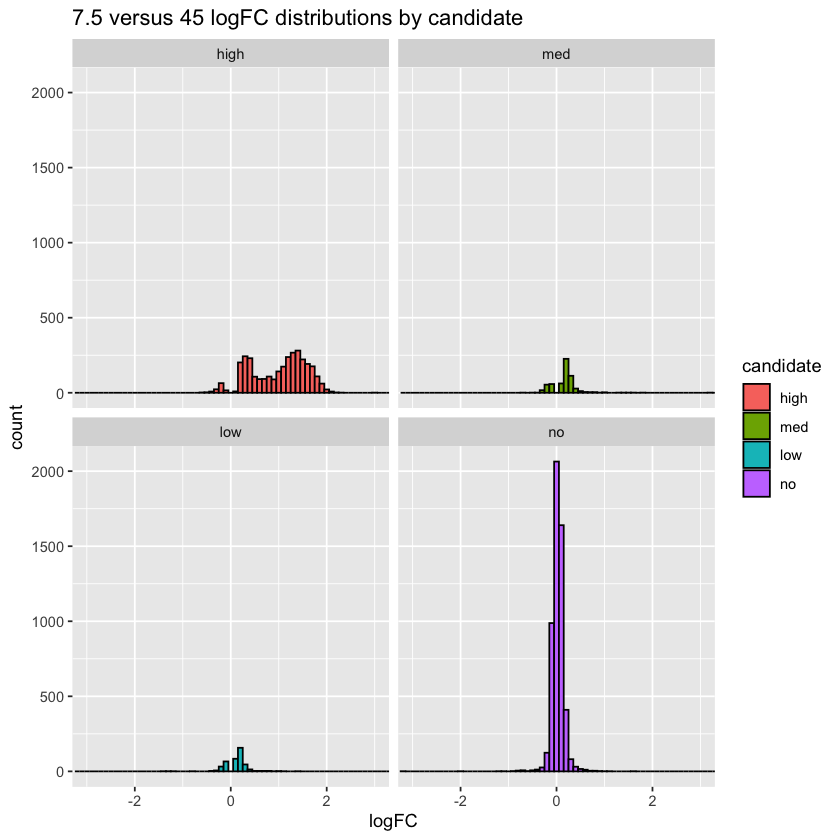

In [16]:
# see how many candidates by category
results %>% count(candidate)

# plot log2 fold-changes by category
ggplot(results, aes(x = logFC, fill = candidate)) +
  geom_histogram(binwidth=0.1, color = "black") +
  facet_wrap(~candidate) +
  coord_cartesian(xlim = c(-3, 3)) +
  ggtitle("7.5 versus 45 logFC distributions by candidate")

### MA plots

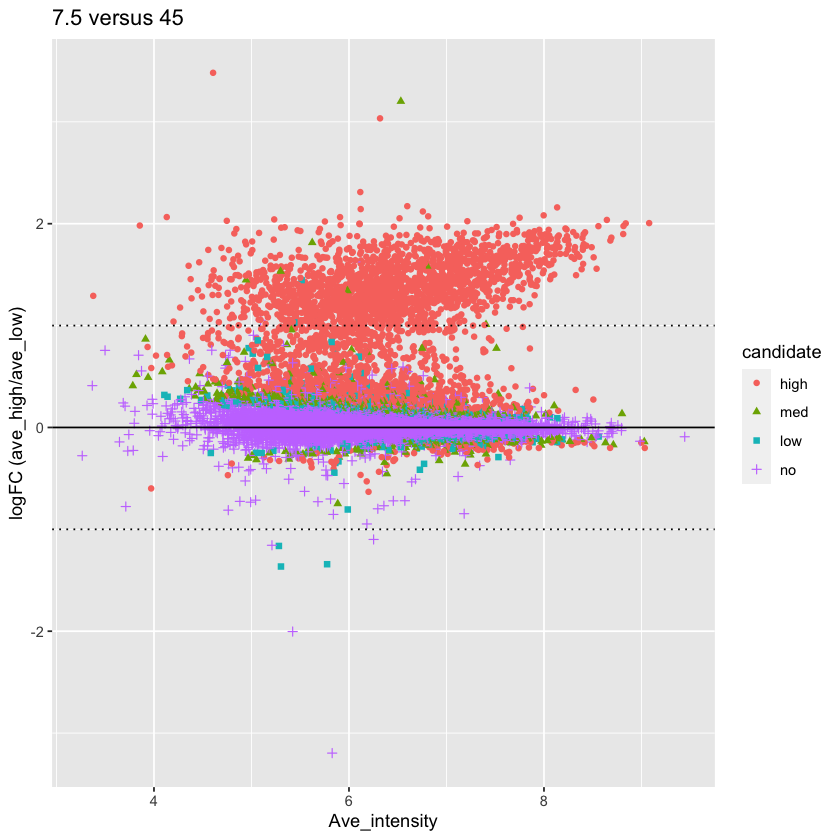

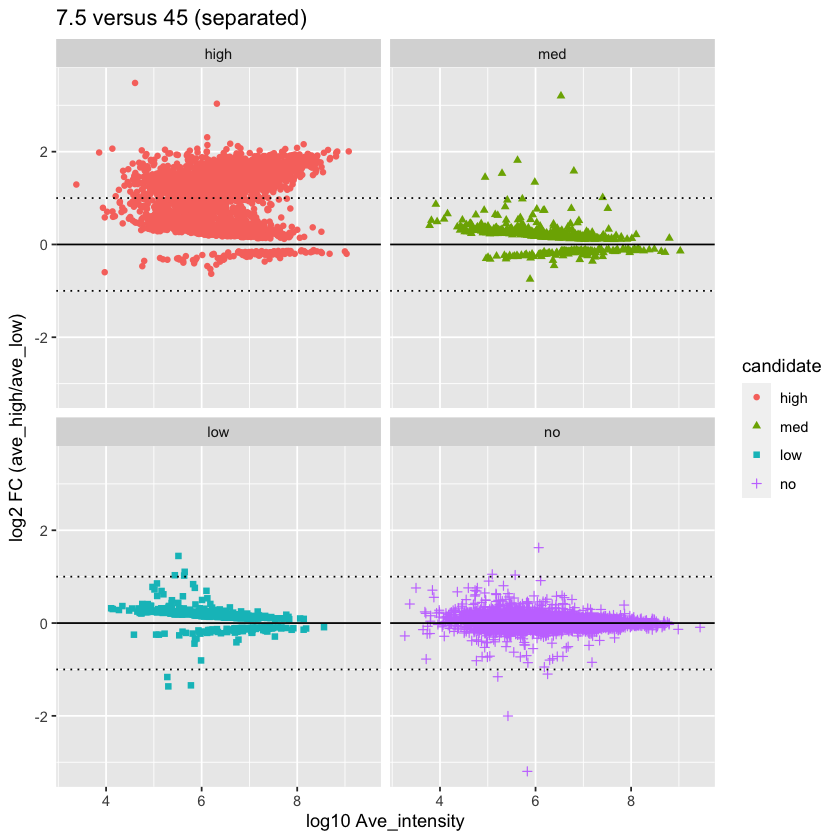

In [17]:
# make MA plots
MA_plots(results, "ave_low", "ave_high", "7.5 versus 45")

### Scatter plots

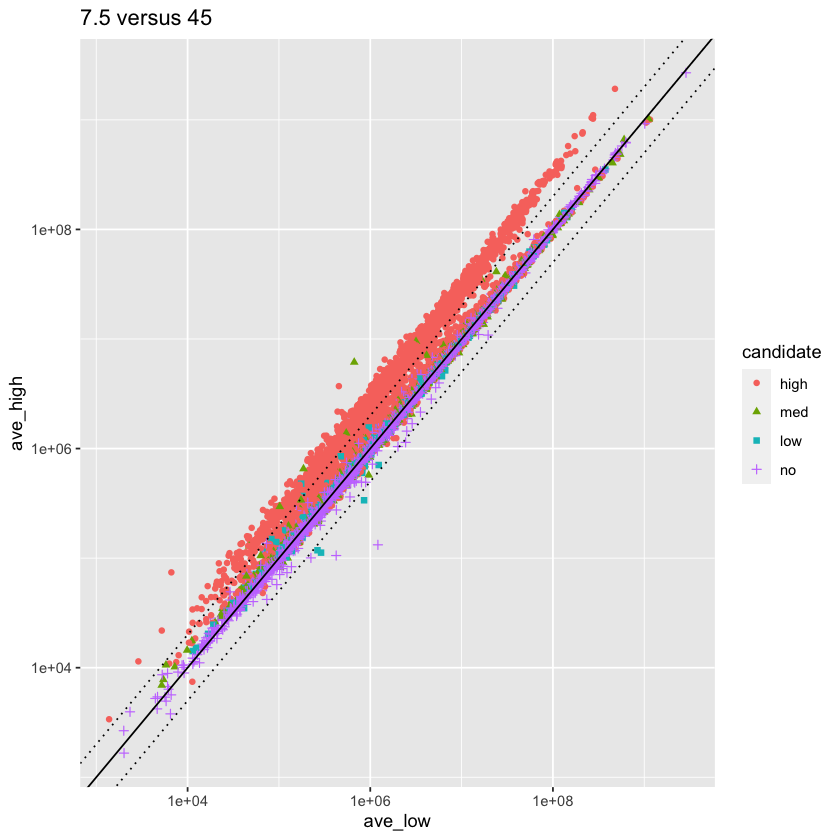

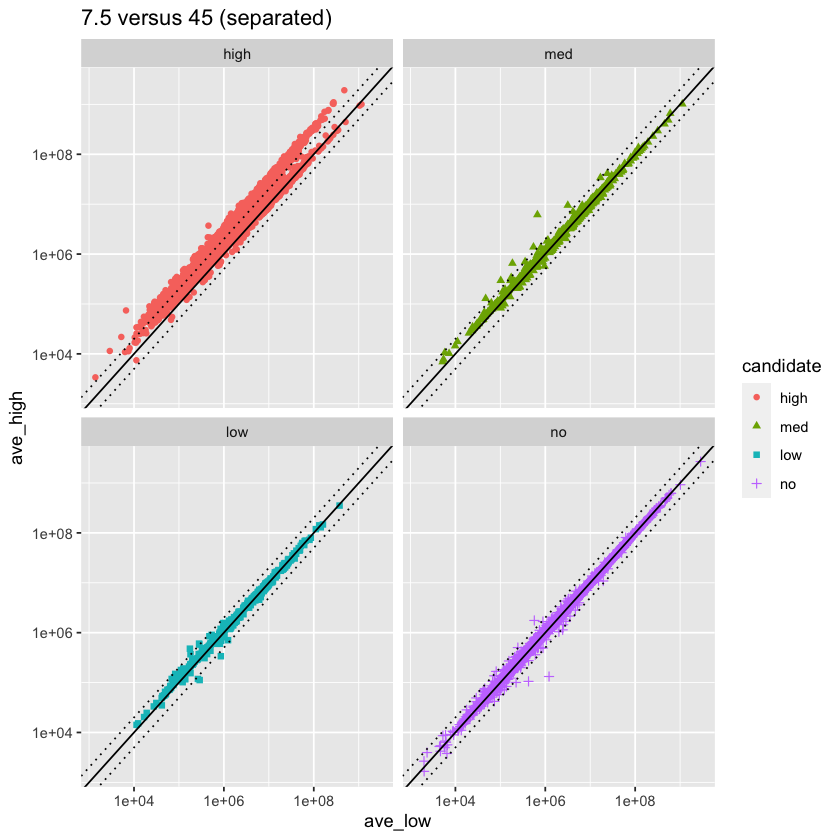

In [18]:
# make scatter plots
scatter_plots(results,  "ave_low", "ave_high", "7.5 versus 45")

### Volcano plot

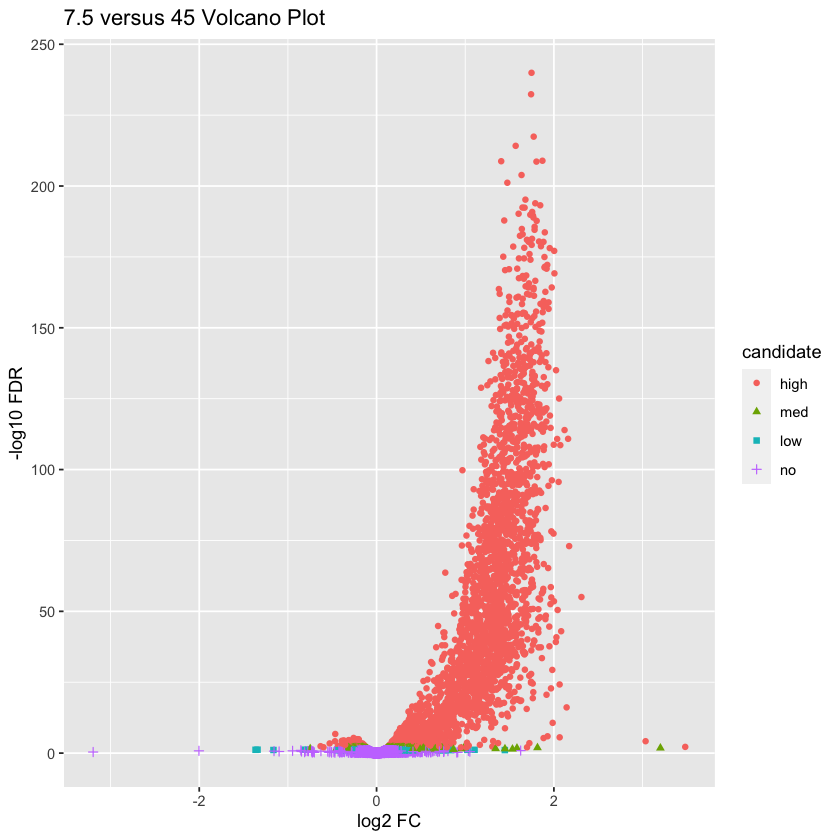

In [19]:
# make a volcano plot
volcano_plot(results,  "ave_low", "ave_high", "7.5 versus 45")

### We have poor distinction between the unchanged background and the spike in proteins

Either the normalization method or the statistical testing (or both) has gone off of the rails.

### Check some individual protein expression

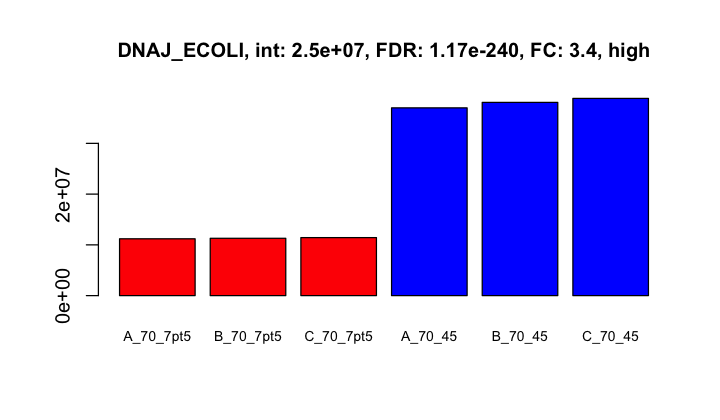

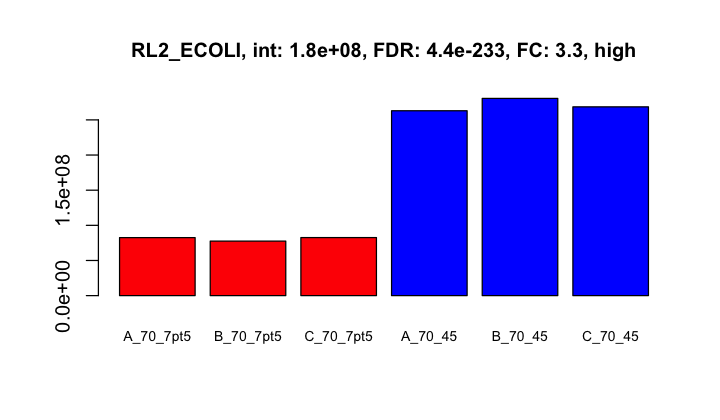

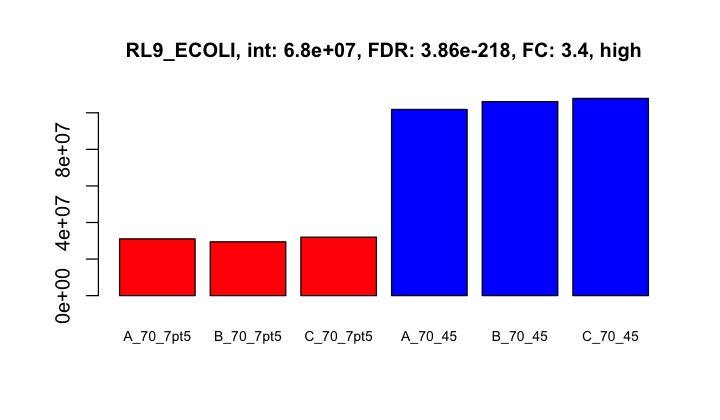

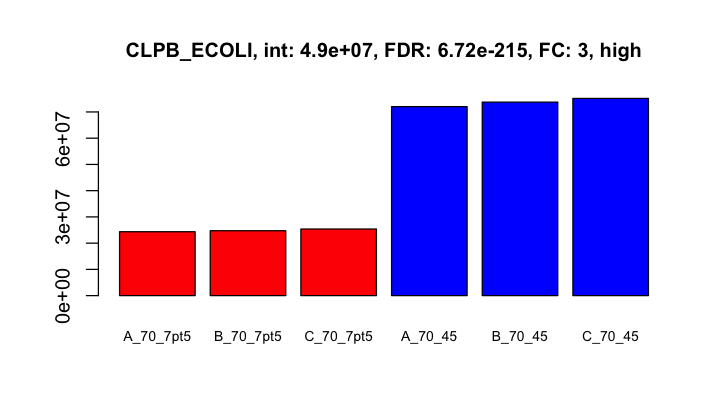

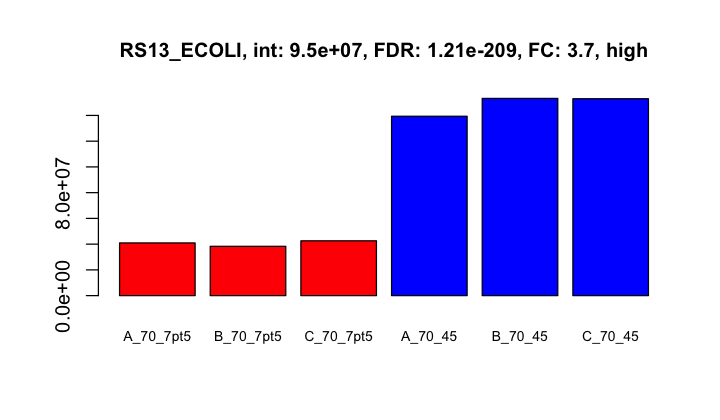

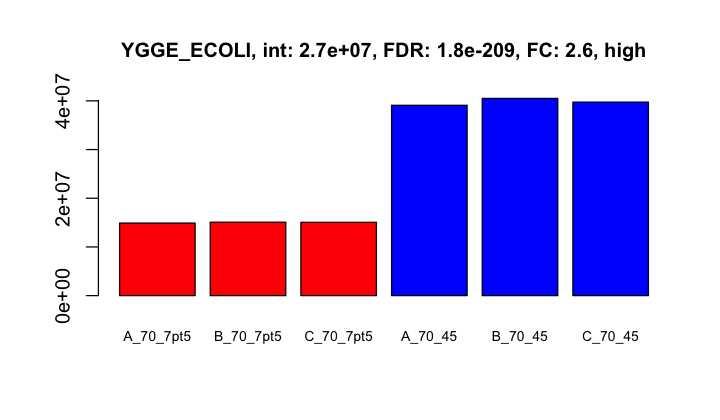

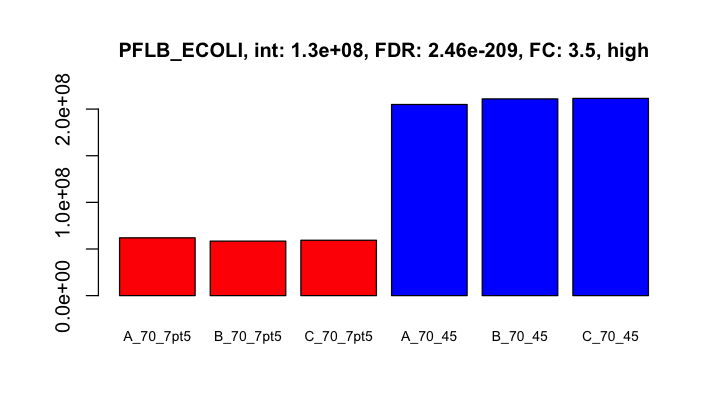

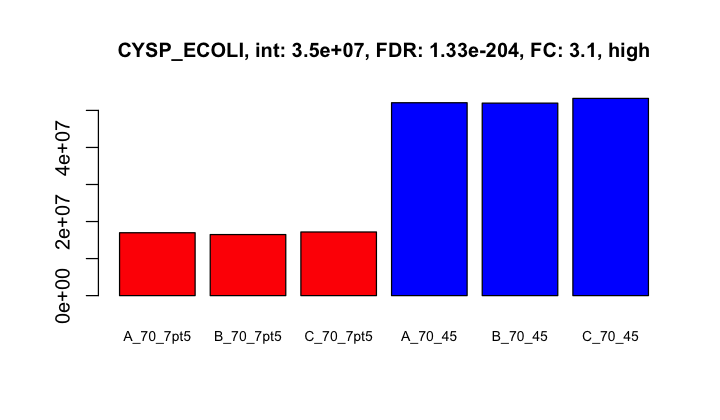

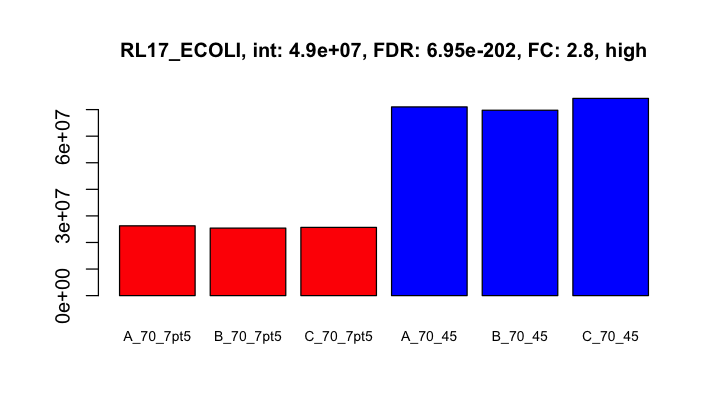

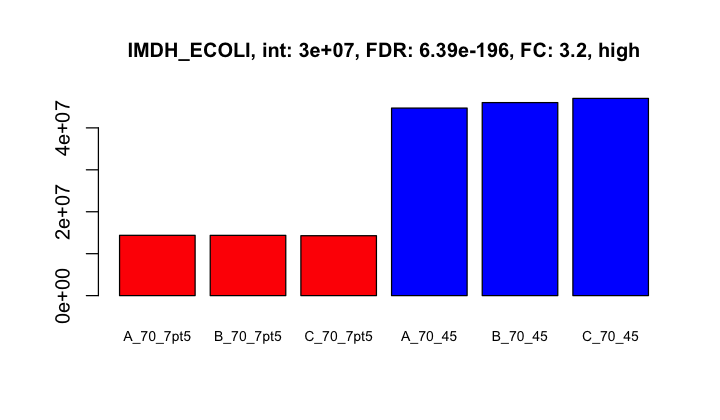

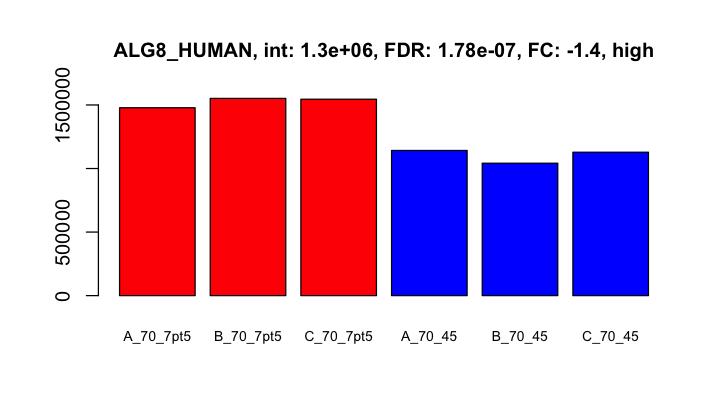

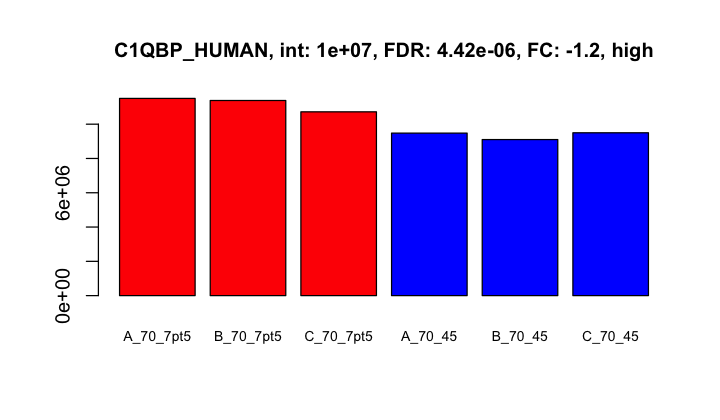

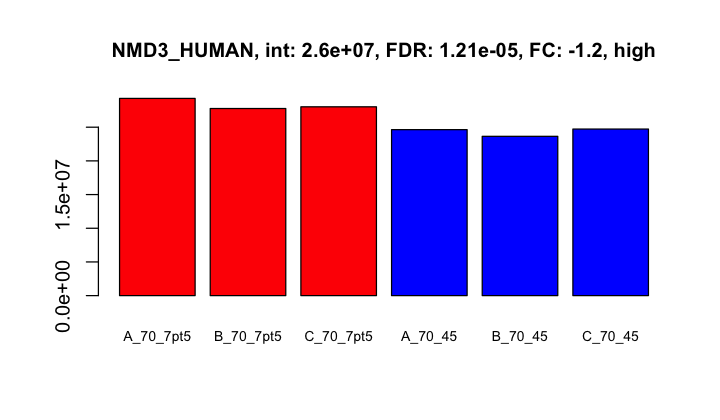

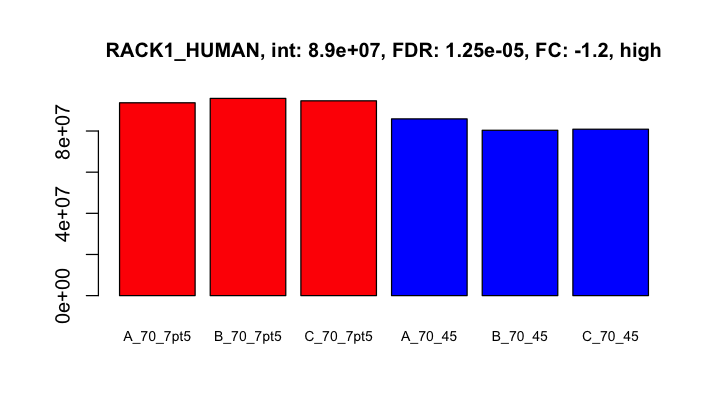

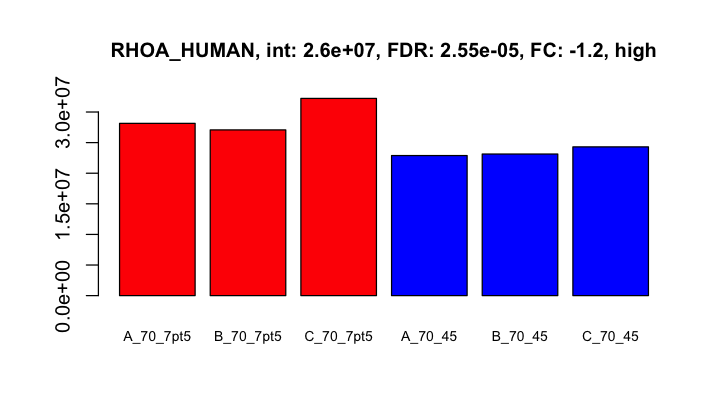

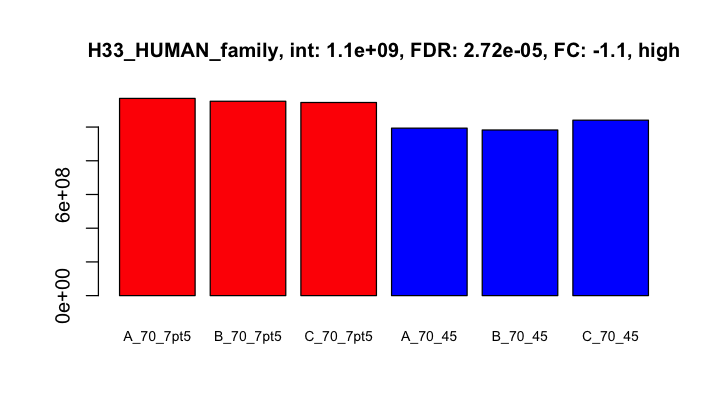

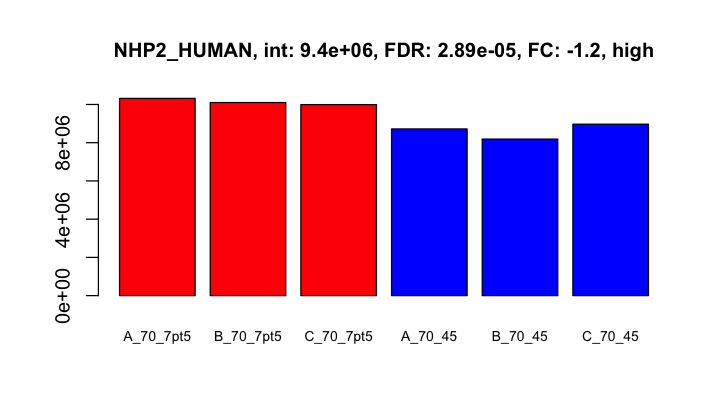

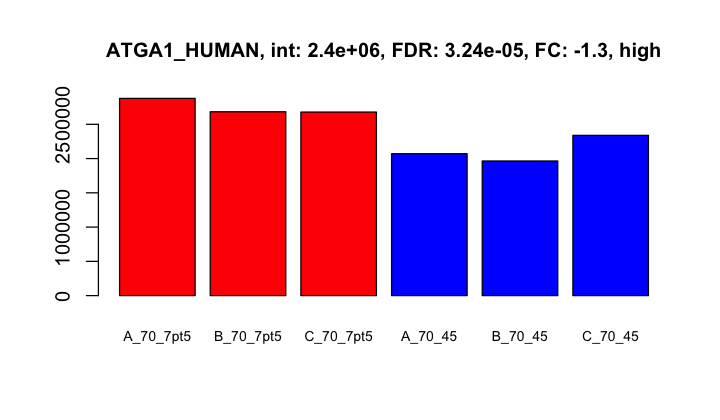

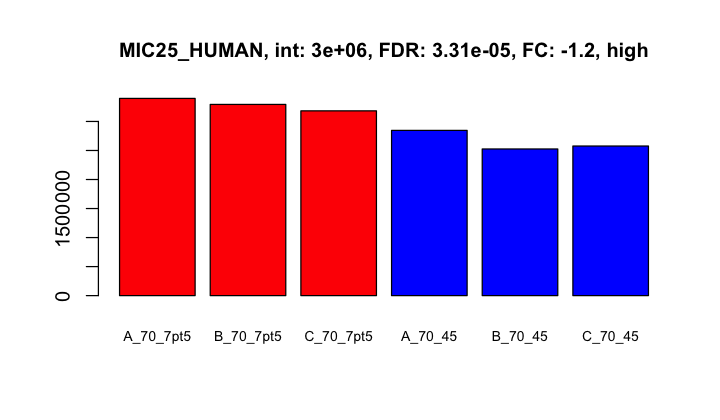

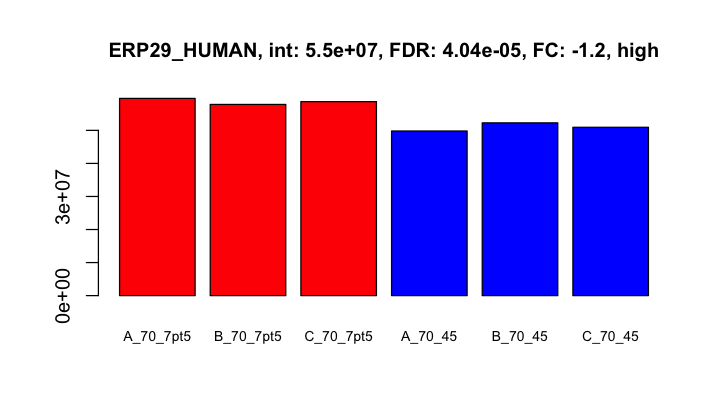

In [20]:
# look at the top candidates
set_plot_dimensions(6, 3.5)
plot_top_tags(results, 3, 3, 10)
set_plot_dimensions(7, 7)

### Individual proteins are consistently expressed at different levels

The over-expressed proteins look like they have true expression differences. All of the top 10 candidates are E. coli proteins. The down expressed proteins are all human and seem to be differing by a little bit. The normalization really should have matched the expression levels more closely. The human proteins are all false positive candidates. 

----

## <a name="15_45"></a> (3) 15 versus 45 microgram E. coli

Compare the last two spike-in levels. We should have 3-fold changes for E. coli proteins and no change for human proteins.

       high-med
Down        161
NotSig     6139
Up         3350

genes                logFC     logCPM    PValue        FDR          
1046 sp|P08622|DNAJ_ECOLI 1.1179413  7.598476 1.095403e-123 1.057064e-119
110  sp|P60422|RL2_ECOLI  1.0996233 10.438795 1.508256e-116 7.277337e-113
929  sp|P0ADS6|YGGE_ECOLI 0.9430304  7.780723 4.142483e-116 1.332499e-112
381  sp|P0A7R1|RL9_ECOLI  1.1362967  9.059921 8.133972e-113 1.962321e-109
538  sp|P63284|CLPB_ECOLI 1.0136090  8.617150 1.367528e-111 2.639329e-108
546  sp|P0AG44|RL17_ECOLI 0.9817481  8.604477 1.399156e-110 2.250309e-107
1775 sp|P75818|YBJP_ECOLI 1.1101728  6.604657 1.394536e-109 1.922467e-106
248  sp|P0A7S9|RS13_ECOLI 1.1947985  9.523020 3.611222e-108 4.356036e-105
765  sp|P16700|CYSP_ECOLI 1.0517367  8.103187 1.152891e-105 1.236156e-102
2124 sp|P31133|POTF_ECOLI 1.0532292  6.203490 9.477404e-103 9.145695e-100

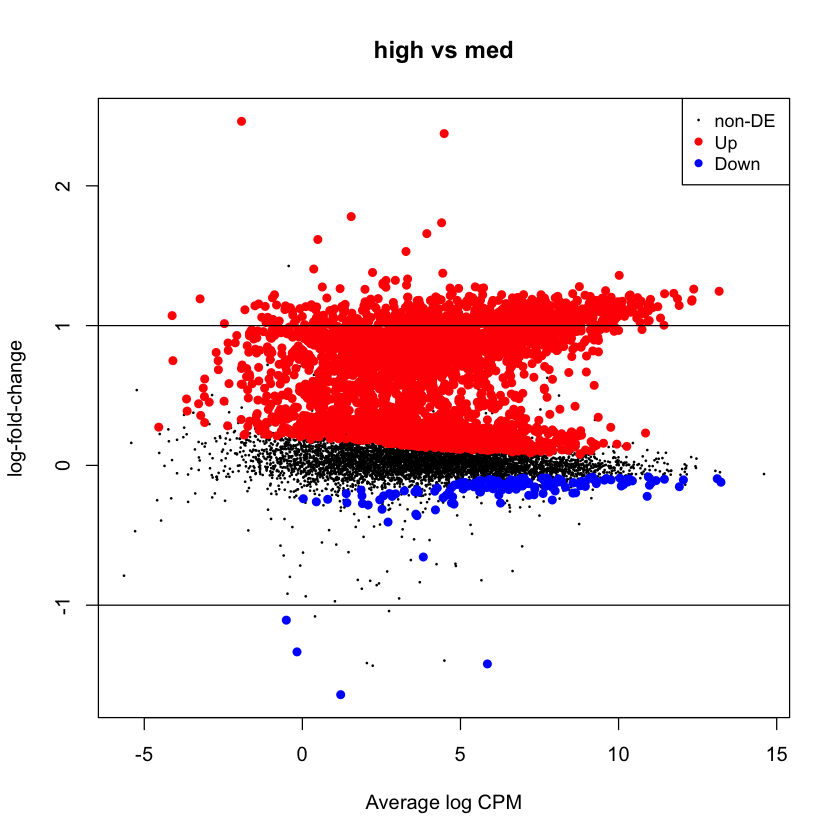

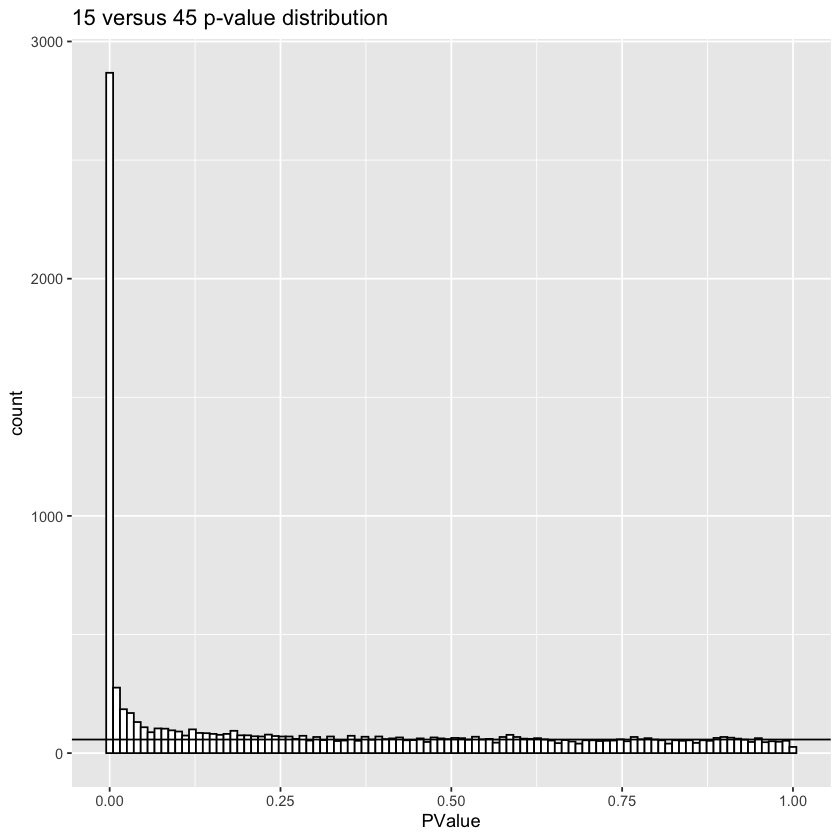

In [21]:
# the exact test object has columns like fold-change, CPM, and p-values
et <- exactTest(y, pair = c("med", "high"))

# this counts up, down, and unchanged genes (proteins) at 10% FDR
summary(decideTestsDGE(et, p.value = 0.10))

# the topTags function adds the BH FDR values to an exactTest data frame 
# make sure we do not change the row order (the sort.by parameter)!
topTags(et)$table
tt <- topTags(et, n = Inf, sort.by = "none")

# make an MD plot (like MA plot)
plotMD(et, p.value = 0.10)
abline(h = c(-1, 1), col = "black")

# check the p-value distribution
ggplot(tt$table, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(et$table$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
  ggtitle("15 versus 45 p-value distribution")

### We have 3,511 candidates  

This comparison looks wrong, too. We have 3-fold E. coli differences instead of 6-fold differences, and the "incorrectness" seems to be similar but reduced.

## Compute averages, flag candidates, and save the pair-wise test results

We will add the statistical testing results (logFC, p-values, and FDR), condition intensity averages, and candidate status to the `results` data frame (which has the TMM-normalized data) and also accumulate all of the three comparisons into `all_results`.

Even though we have few candidates, we will still make the MA plot, scatter plot, and volcano plot.

In [22]:
# get the results summary
results <- collect_results(tmt_tmm, tt$table, med, "med", high, "high")
results$species <- as.factor(species)

# make column names unique by adding comparison
results_temp  <- results
colnames(results_temp) <- str_c(colnames(results), "_med_high")

# accumulate the testing results
all_results <- cbind(all_results, results_temp)

### Count candidates and look at fold-change distributions

candidate n   
1 high      2767
2 med        400
3 low        344
4 no        6139

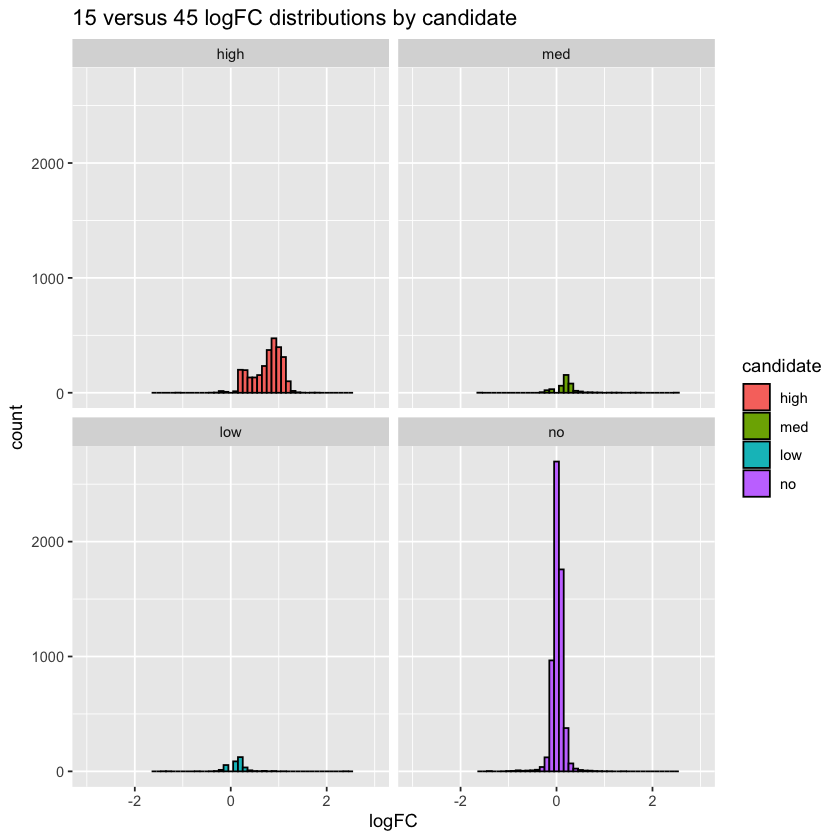

In [23]:
# see how many candidates by category
results %>% count(candidate)

# plot log2 fold-changes by category
ggplot(results, aes(x = logFC, fill = candidate)) +
  geom_histogram(binwidth=0.1, color = "black") +
  facet_wrap(~candidate) +
  coord_cartesian(xlim = c(-3, 3)) +
  ggtitle("15 versus 45 logFC distributions by candidate")

### MA plots

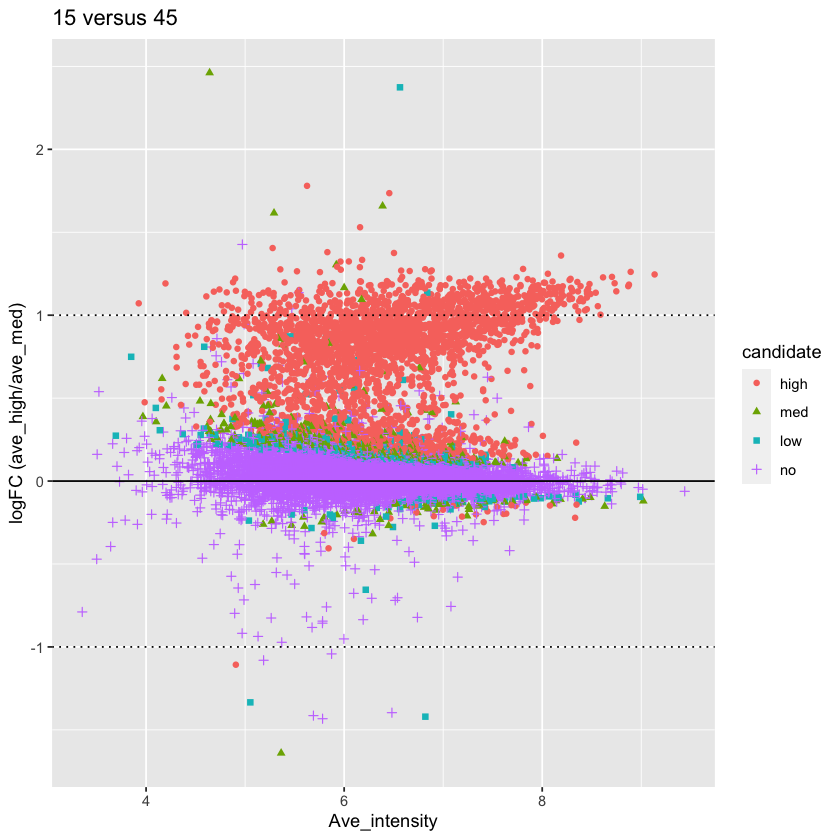

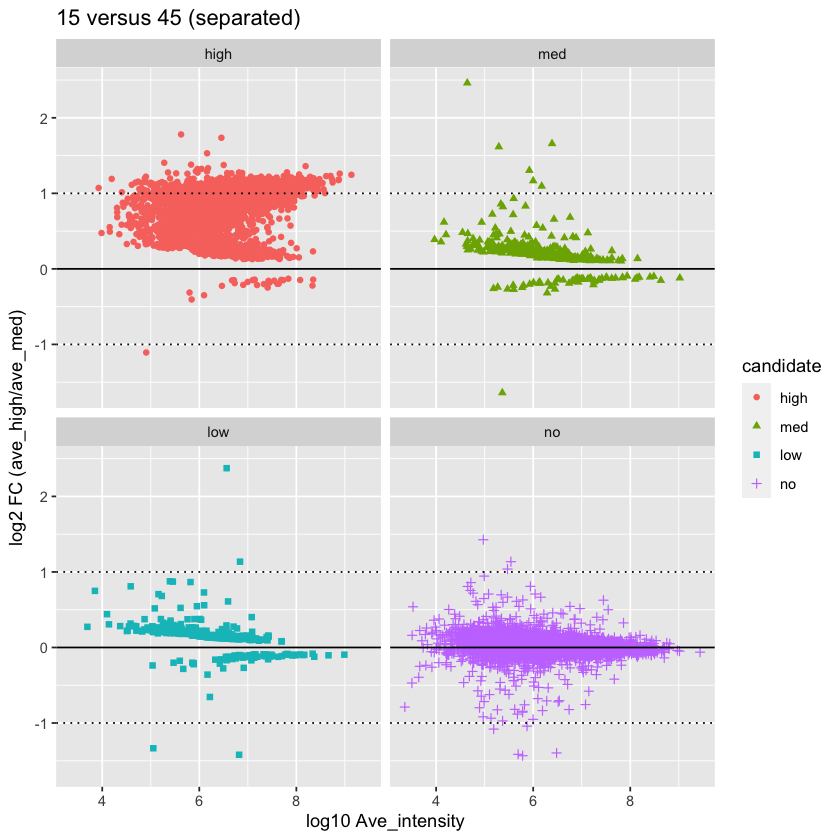

In [24]:
# make MA plots
MA_plots(results, "ave_med", "ave_high", "15 versus 45")

### Scatter plots

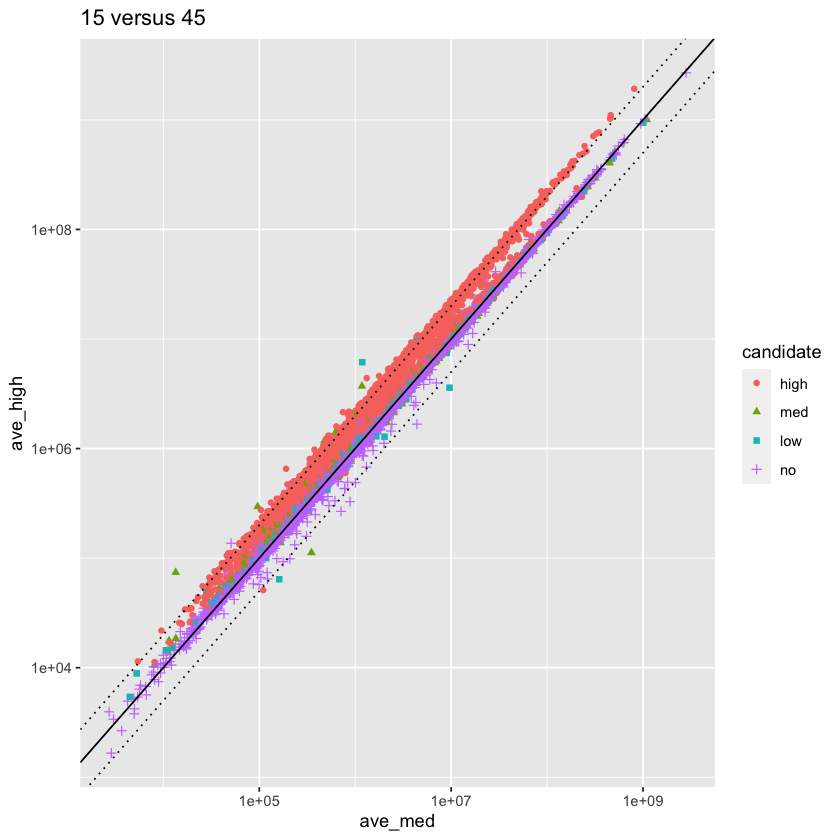

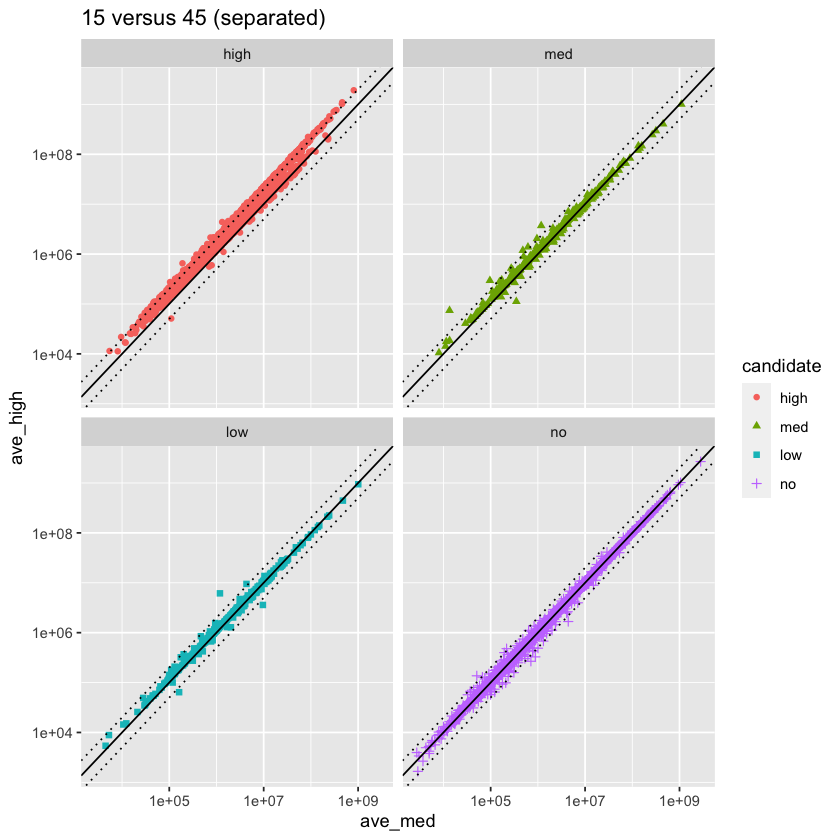

In [25]:
# make scatter plots
scatter_plots(results, "ave_med", "ave_high", "15 versus 45")

### Volcano plot

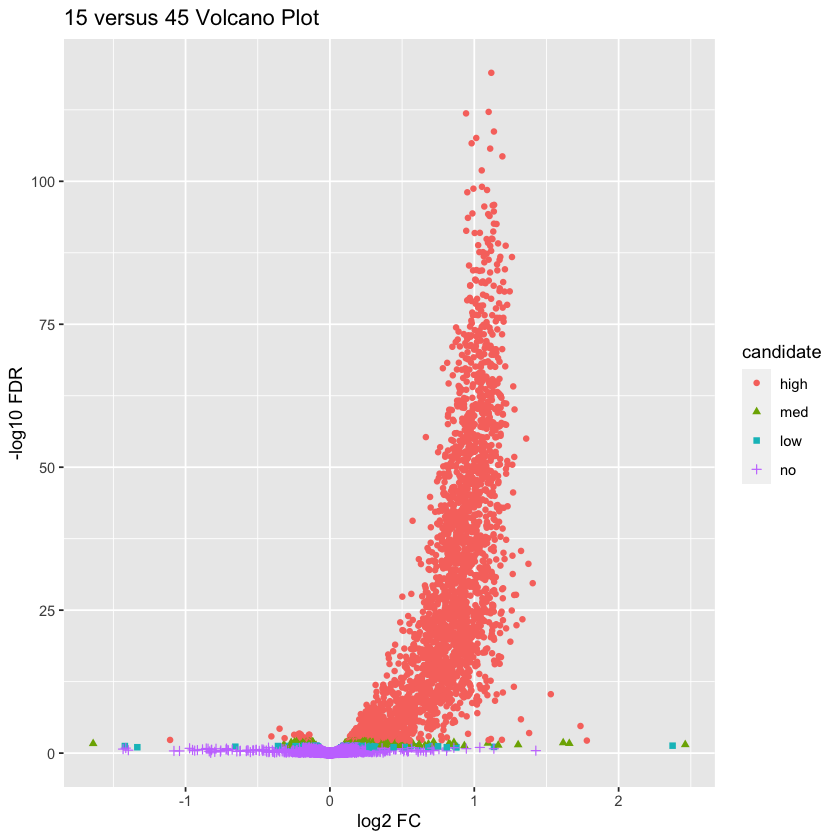

In [26]:
# make a volcano plot
volcano_plot(results, "ave_med", "ave_high", "15 versus 45")

### We have a large number of human false positive candidates

We have plots that look like what we saw in the second comparison, but with a reduced number of human false positives (maybe 1,300 instead of 2,000).

### Check individual protein expression

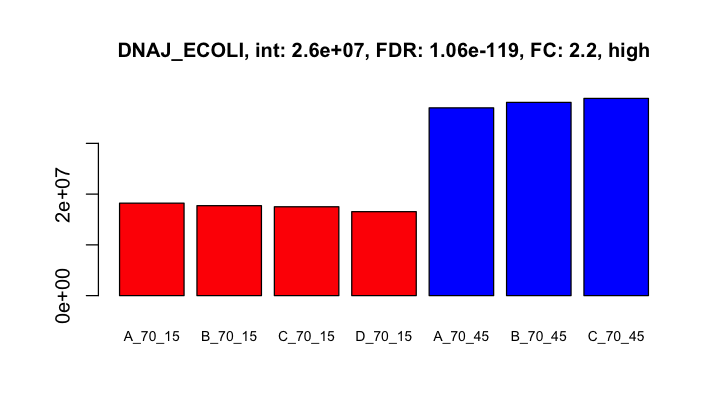

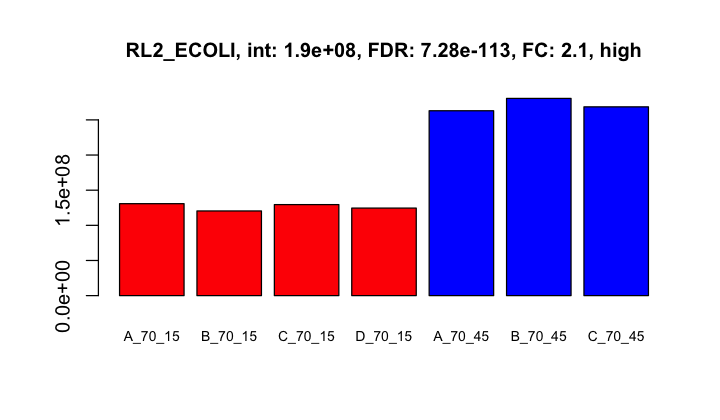

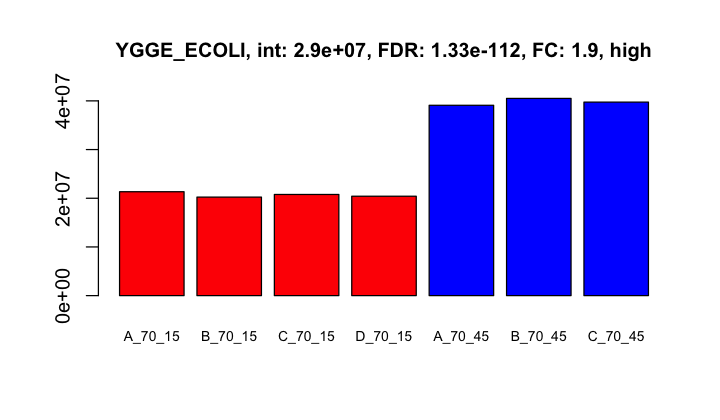

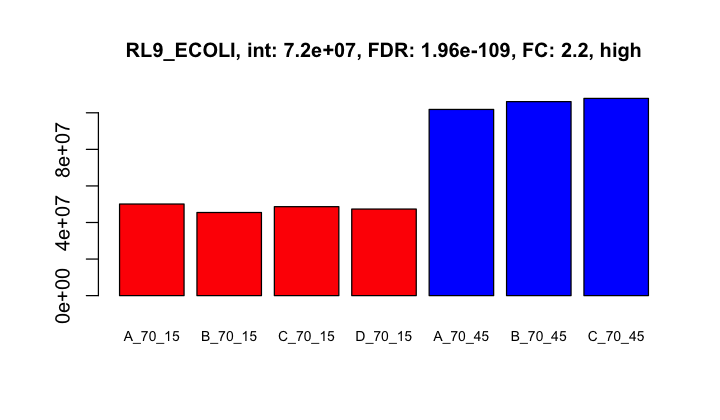

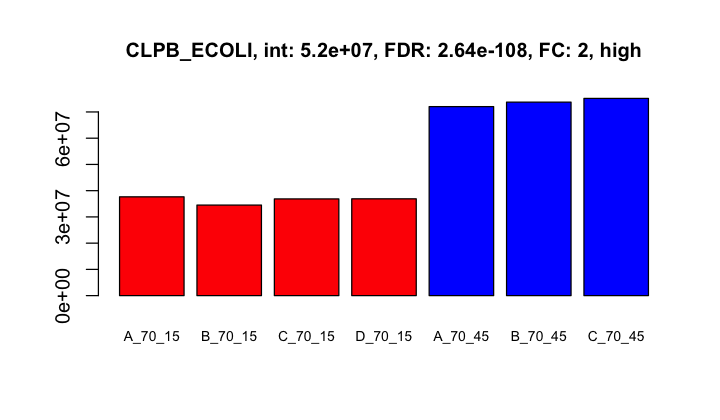

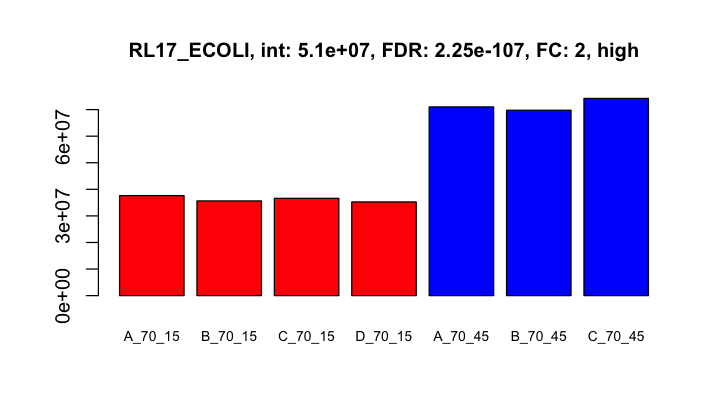

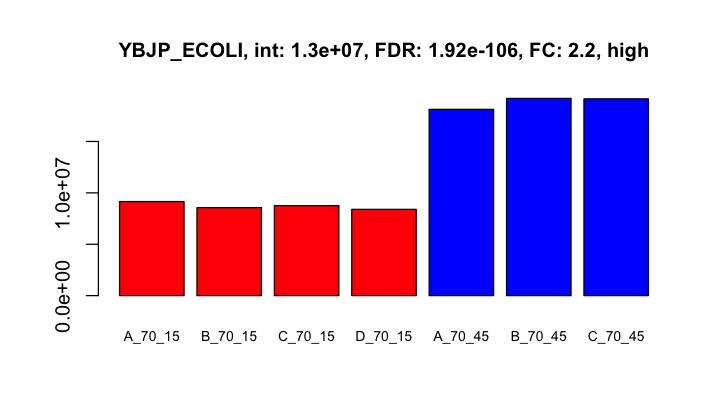

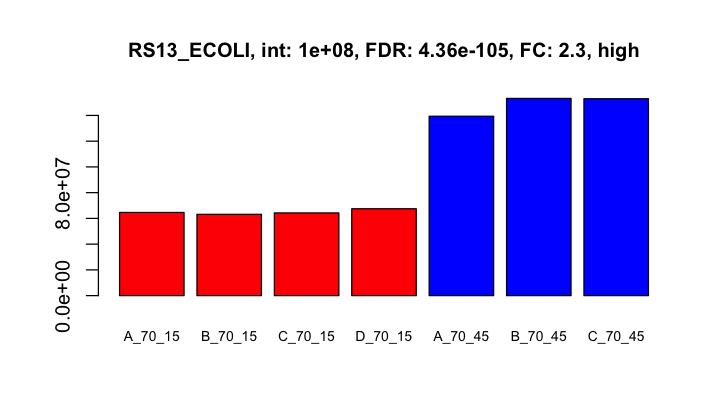

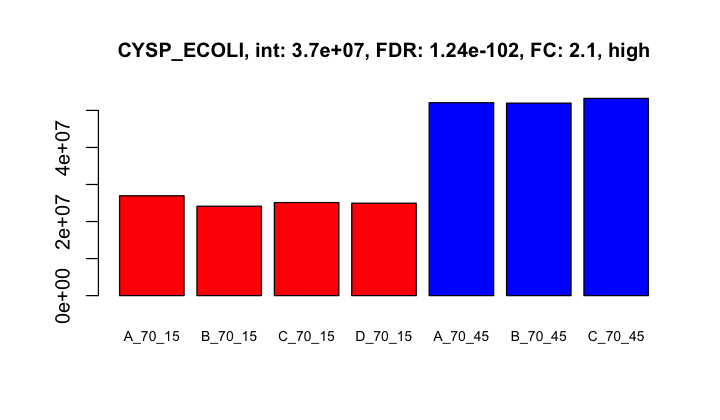

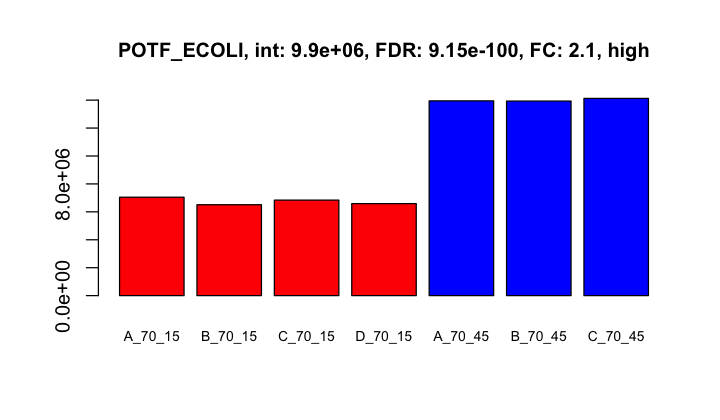

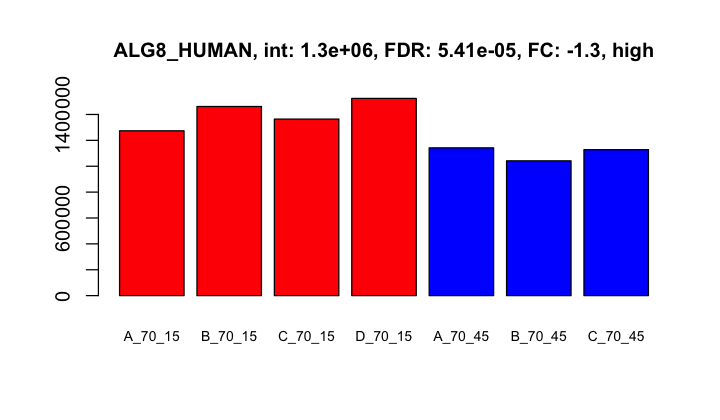

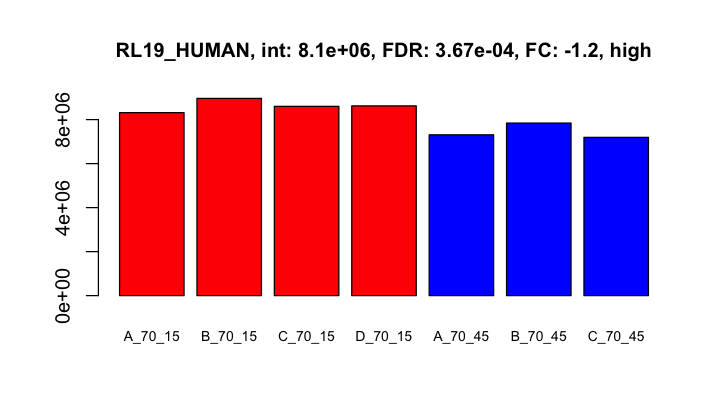

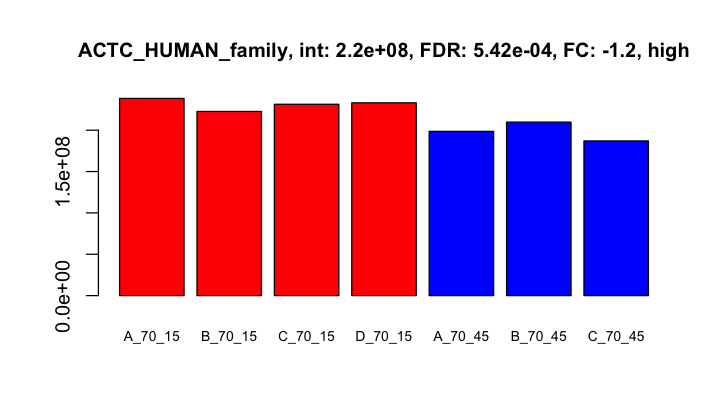

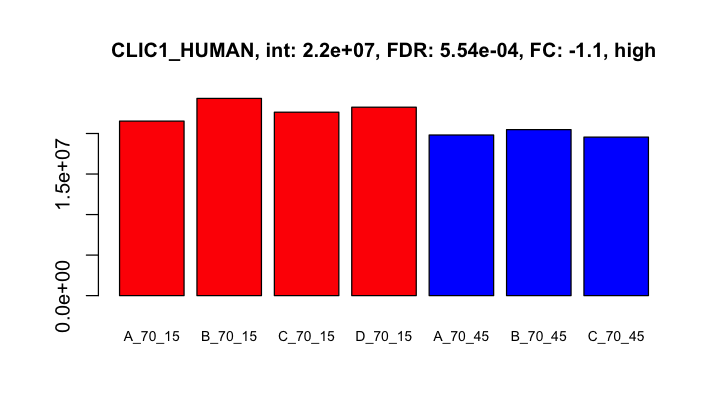

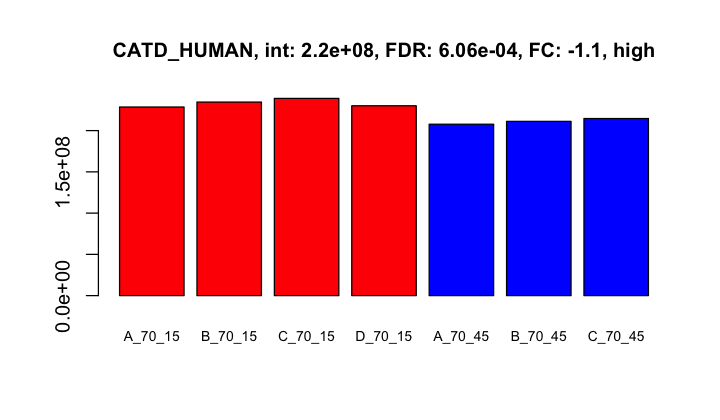

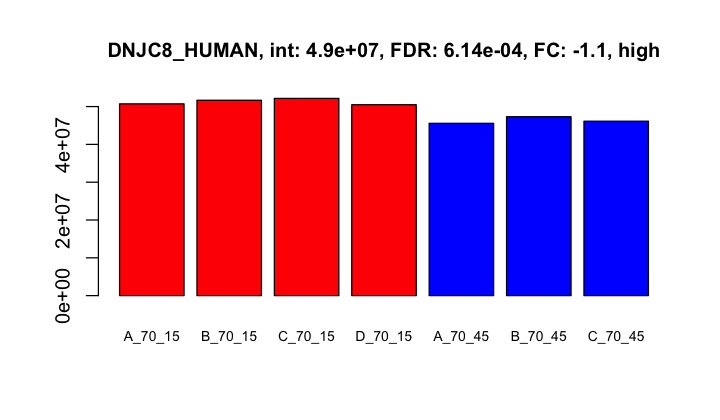

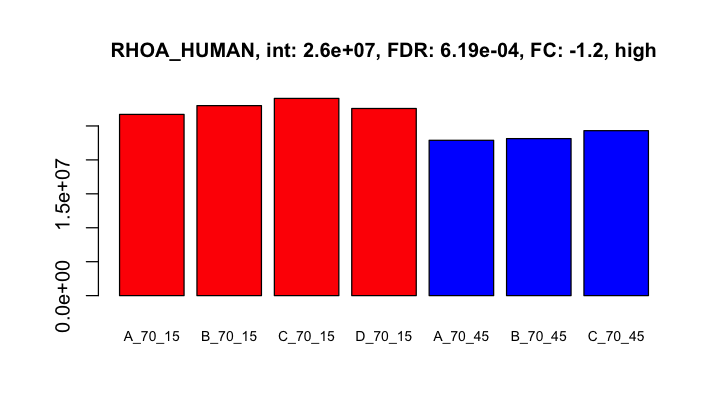

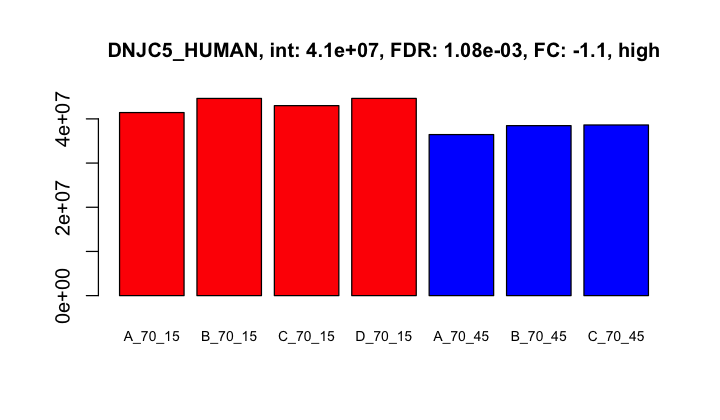

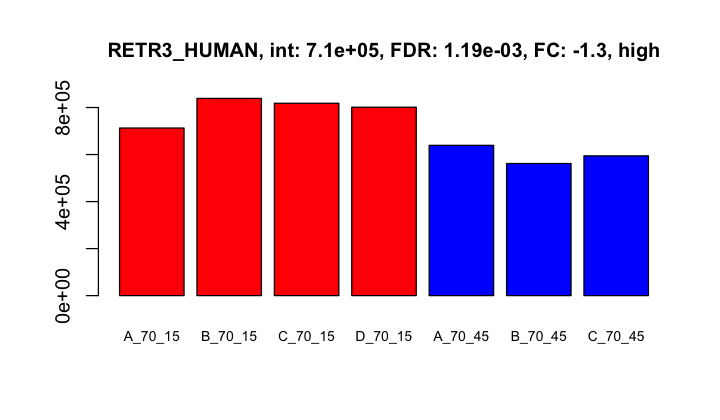

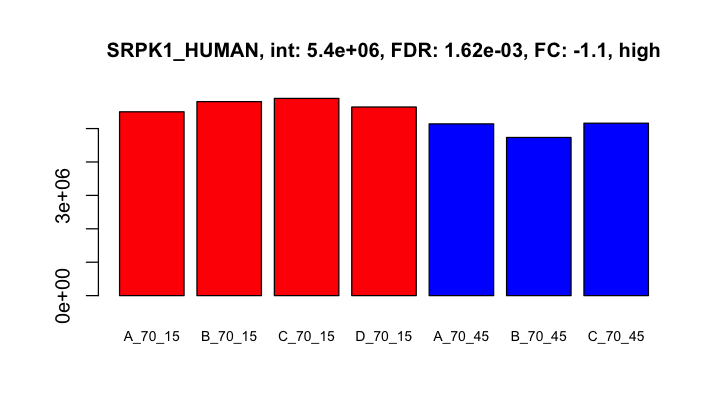

In [27]:
# look at the top candidates
set_plot_dimensions(6, 3.5)
plot_top_tags(results, 4, 3, 10)
set_plot_dimensions(7, 7)

### Over-expressed candidates are E. coli proteins

The top over-expressed proteins are all E. coli proteins. We expect 3-fold changes, but see 2-fold changes. We have some small systematic under-normalization of the human proteins. We did match the total of all human proteins to be the same. The down-regulated human proteins above end up with slightly different expression levels after the normalization. They should have been better aligned if our understanding of the data were correct.

---

## <a name="summary"></a> Summary

We tried to compensate for possible violations of the normalization assumptions in edgeR's TMM algorithm by doing a simple manual normalization to match the human protein levels. That really did not change the poor statistical testing outcomes much over just using TMM.

---
## Save the `all_results` frame to TSV file

In [28]:
write.table(all_results, "edgeR_no-norm_results.txt", sep = "\t",
           row.names = FALSE, na =  " ")

## Log the session information

In [29]:
sessionInfo()

R version 3.5.3 (2019-03-11)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.15.5

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] psych_1.9.12.31 edgeR_3.24.3    limma_3.38.3    scales_1.1.0   
 [5] forcats_0.5.0   stringr_1.4.0   dplyr_0.8.5     purrr_0.3.3    
 [9] readr_1.3.1     tidyr_1.0.2     tibble_2.1.3    ggplot2_3.3.0  
[13] tidyverse_1.3.0

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.4       locfit_1.5-9.1   lubridate_1.7.4  lattice_0.20-40 
 [5] assertthat_0.2.1 digest_0.6.25    IRdisplay_0.7.0  R6_2.4.1        
 [9] cellranger_1.1.0 repr_1.1.0       backports_1.1.5  reprex_0.3.0    
[13] evaluate